## Giới thiệu chung
### Đề tài
* **Tìm hiểu về dữ liệu âm thanh**
* **Xây dựng mô hình phân loại thể loại âm nhạc**
* **Xây dựng hệ thống đề xuất nhạc cơ bản**

### Các thành viên trong nhóm
* Trần Trọng Kiên - 22110093
* Châu Gia Kiệt - 22110095
* Trương Hồng Kiệt - 22110096
* Trương Minh Quân - 22110172

### Tên của bộ dữ liệu  - GTZAN Dataset: the MNIST of sounds

**1. Thể loại âm nhạc (Genres Original):**  
Bộ dữ liệu gồm **10 thể loại nhạc**, mỗi thể loại chứa **100 tệp âm thanh**, mỗi tệp dài **30 giây**.  

**2. Hình ảnh đại diện (Images Original):**  
Mỗi tệp âm thanh được biểu diễn dưới dạng hình ảnh trực quan, cụ thể là **Mel Spectrogram**. Điều này giúp chúng ta dễ dàng sử dụng **Neural Networks** để phân loại, đặc biệt là **CNN (Convolutional Neural Networks)**.  

**3. 2 tệp CSV:**  
Bộ dữ liệu còn đi kèm **2 tệp CSV** chứa các đặc trưng của tệp âm thanh:  
- **Tệp thứ nhất:** Tóm tắt mỗi bài hát (30 giây) bằng **giá trị trung bình** và **phương sai** của nhiều đặc trưng âm thanh.  
- **Tệp thứ hai:** Chia mỗi bài hát thành các đoạn âm thanh ngắn hơn (**3 giây**), giúp tăng lượng dữ liệu lên **gấp 10 lần**, vì với dữ liệu, **càng nhiều càng tốt**.  

### Nội dung trình bày:
* **Tìm hiểu và trực quan hoá dữ liệu âm thanh** (cụ thể là âm nhạc) sử dụng thư viện `librosa`
* **Khai phá bộ dữ liệu**
* **Phân loại thể loại âm nhạc** (Music Genres Classification) bằng máy học (Machine Learning)
* Xây dựng hệ thống **đề xuất âm nhạc** đơn giản (Music Recommendation System)

## Các thư viện cần thiết

In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Lấy bộ dữ liệu từ Kaggle

In [ ]:
import kagglehub
andradaolteanu_gtzan_dataset_music_genre_classification_path = kagglehub.dataset_download('andradaolteanu/gtzan-dataset-music-genre-classification')

100%|██████████| 1.21G/1.21G [00:11<00:00, 116MB/s]

Extracting files...


In [ ]:
general_path = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data'
print(list(os.listdir(f'{general_path}/genres_original/')))

['classical', 'country', 'metal', 'reggae', 'hiphop', 'jazz', 'rock', 'disco', 'blues', 'pop']


## Dữ liệu âm thanh
* Âm thanh: Chuỗi dao động với cường độ áp suất thay đổi (`y`)
* Tần số mẫu (Sample Rate): **Sample rate** là số lượng mẫu âm thanh có thể thu thập từ tệp âm thanh trong mỗi giây. Mỗi mẫu (sample) có thể chứa các đặc trưng của âm thanh mà ta sẽ tìm hiểu thêm bên dưới. Tần số mẫu có thể được đo bằng đơn vị `Hz` hoặc `kHz`.
* Hàm `load` trong thư viện `librosa` (`librosa.load`) có thể giúp ta trích xuất chuỗi âm thanh dưới dạng số (mảng số thực) và tần số mẫu (sample rate) phục vụ cho việc phân tích âm thanh.

In [ ]:
# Importing 1 file
y, sr = librosa.load(f'{general_path}/genres_original/rock/rock.00050.wav')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', 661794/22050)

y: [0.14434814 0.2128601  0.19824219 ... 0.09204102 0.07012939 0.04364014] 

y shape: (661794,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 30.013333333333332


In [ ]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0.14434814 0.2128601  0.19824219 ... 0.09204102 0.07012939 0.04364014] 

Audio File shape: (661794,)


## Tìm hiểu và trực quan hoá các đặc trưng của âm thanh (âm nhạc)

Trong phần này, ta sẽ sử dụng thư viện `librosa` và `matplotlib.pyplot` để tìm hiểu và biểu diễn các đặc trưng của âm thanh bằng hình ảnh.

### Trực quan hoá sóng âm thanh

Biểu diễn sóng âm thanh trên độ dài đầy đủ của tệp âm thanh

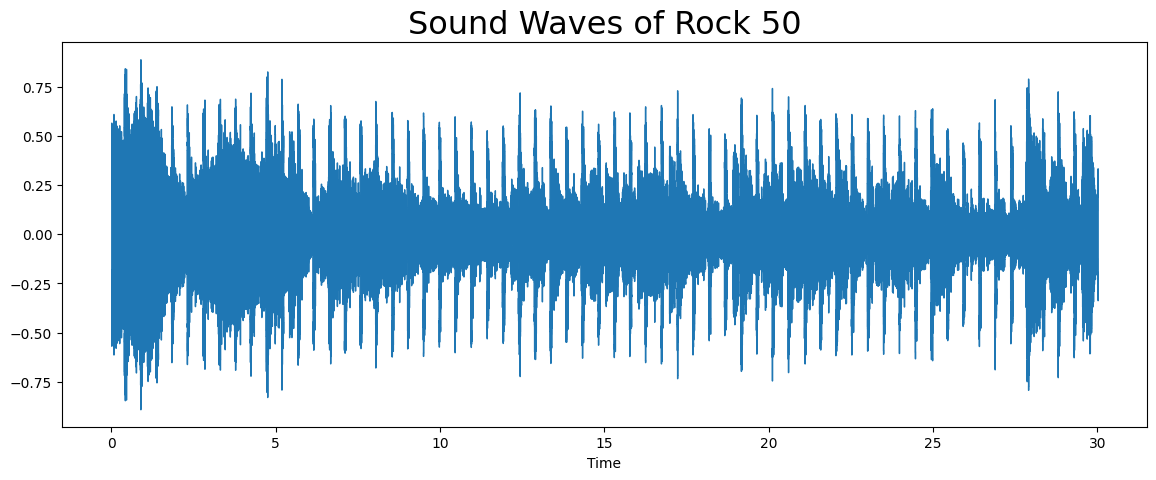

In [ ]:
plt.figure(figsize = (14, 5))
librosa.display.waveshow(y = audio_file, sr = sr);
plt.title("Sound Waves of Rock 50", fontsize = 23);

Biểu diễn sóng âm thanh trên từng đoạn ngắn của tệp âm thanh (trong ví dụ này ta sẽ chia tệp âm thanh thành nhiều đoạn, mỗi đoạn khoảng 4 giây và vẽ sóng âm thanh của từng đoạn ra).

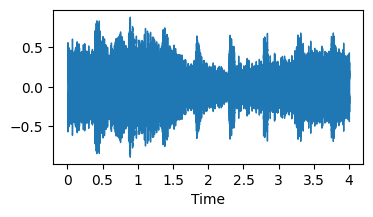

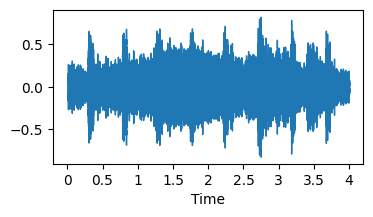

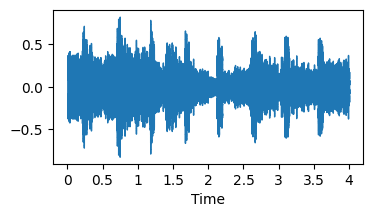

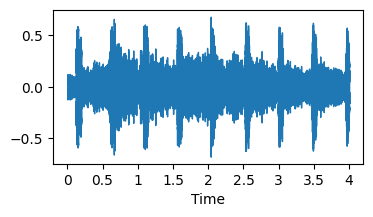

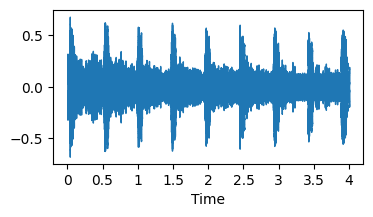

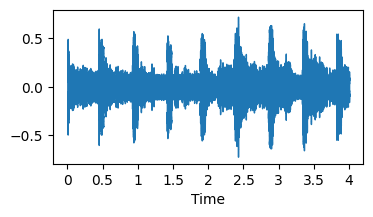

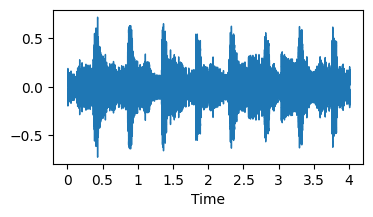

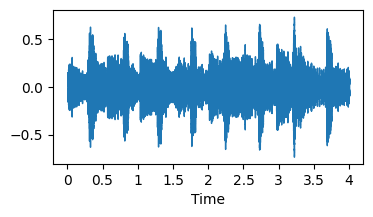

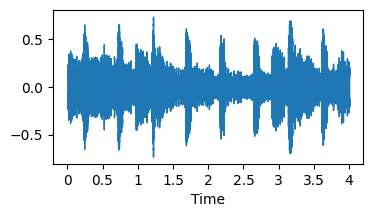

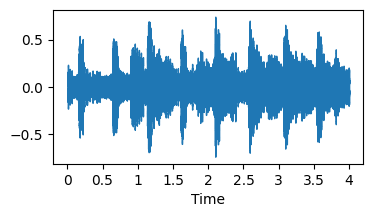

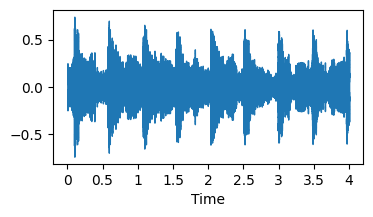

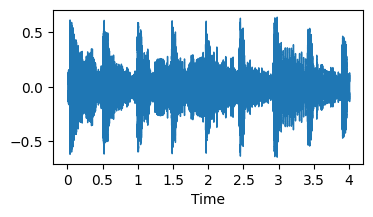

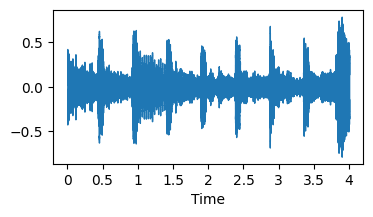

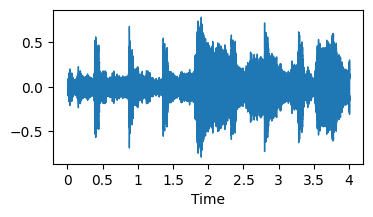

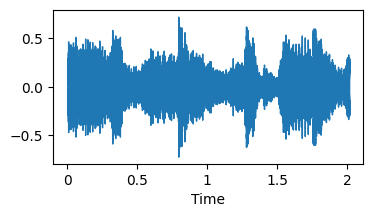

In [ ]:
# Define the duration of each chunk and overlap
chunk_duration = 4  # seconds
overlap_duration = 2  # seconds

# Convert durations to samples
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

# Calculate the number of chunks
num_chunks = int(np.ceil((len(audio_file) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

# Iterate over each chunk
for i in range(num_chunks):
    # Calculate start and end indices of the chunk
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples

    # Extract the chunk of audio
    chunk = audio_file[start:end]
    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()

### Trực quan hoá phổ của âm thanh trên thang đo Mel (Mel Spectrogram)

* Trước tiên, ta cần hiểu biểu đồ phổ biểu diễn tần số của một tín hiệu khi nó thay đổi theo thời gian. Nó giúp chúng ta quan sát cách năng lượng của các thành phần tần số khác nhau thay đổi theo thời gian như âm thanh.
* Mel Spectrogram là một dạng biểu đồ phổ mà trong đó tần số được ánh xạ sang thang Mel - một thang đo tần số dựa trên cách con người cảm nhận âm thanh. Thang Mel gần giống với cách tai người phân biệt âm thanh ở các tần số khác nhau.
* Có thể tìm hiểu thêm ở [đây](https://en.wikipedia.org/wiki/Spectrogram)

In [ ]:
#Plotting Melspectrogram of Entire Audio
def plot_melespectrogram(y,sr):
    #Compute spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y,sr=sr)
    #Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
    #Visualize the spectrogram
    plt.figure(figsize=(10,4))
    librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
    plt.colorbar(format='%2.0f dB')
    plt.title("Spectrogram")
    plt.tight_layout()
    plt.show()

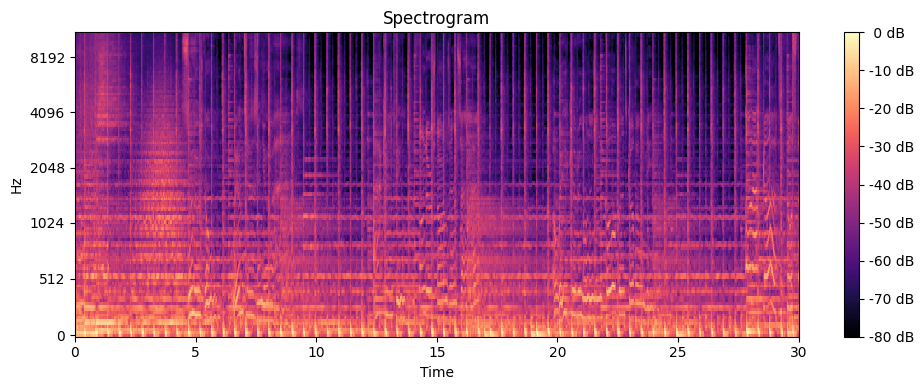

In [ ]:
plot_melespectrogram(audio_file,sr)

Tương tự như phần trước, ta cũng có thể vẽ Mel Spectrogram của từng phần trong tệp âm thanh khi ta chia nó ra thành nhiều phần có chiều dài như nhau.

In [ ]:
def plot_melspectrogram_chunks(y,sr):
    #define the duration of each chunk and overlap
    chunk_duration = 4
    overlap_duration = 2

    #Convert duration to sample
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    #Calculate the number of chunks
    num_chunks = int(np.ceil((len(y)-chunk_samples)/(chunk_samples-overlap_samples)))+1

    #iterate over each chunks
    for i in range(num_chunks):
        #Calculate start and end indices of the chunk
        start = i*(chunk_samples-overlap_samples)
        end = start+chunk_samples
        #Extract the chunk audio
        chunk = y[start:end]
        #Melspectrogram part
        spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sr)
        print(spectrogram.shape)
        spectrogram_db = librosa.power_to_db(spectrogram,ref=np.max)
        #Visualize the spectrogram
        plt.figure(figsize=(10,4))
        librosa.display.specshow(spectrogram_db,sr=sr,x_axis='time',y_axis='mel')
        plt.colorbar(format='%2.0f dB')
        plt.title("Spectrogram")
        plt.tight_layout()
        plt.show()

(128, 173)


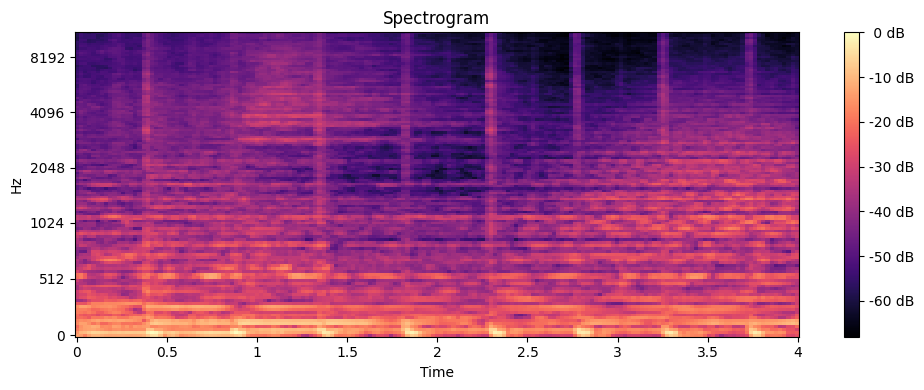

(128, 173)


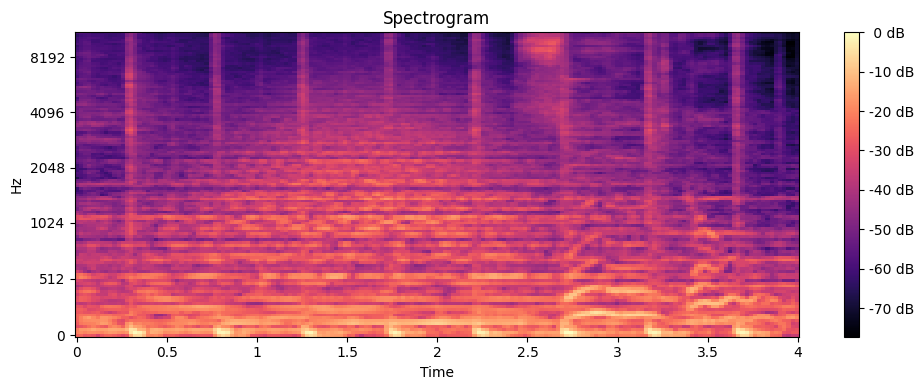

(128, 173)


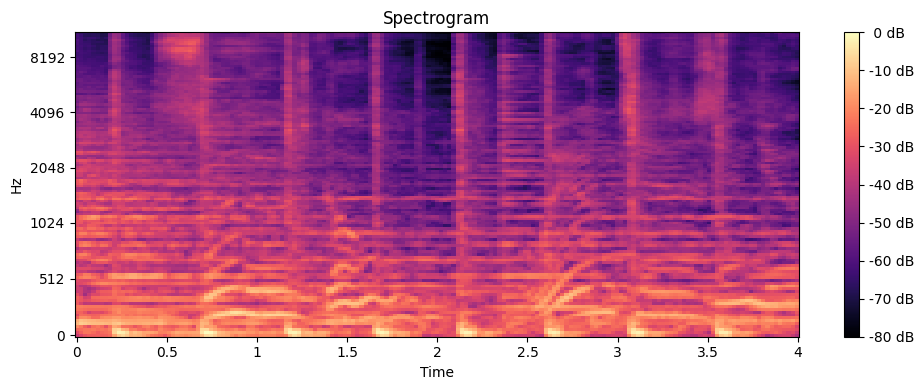

(128, 173)


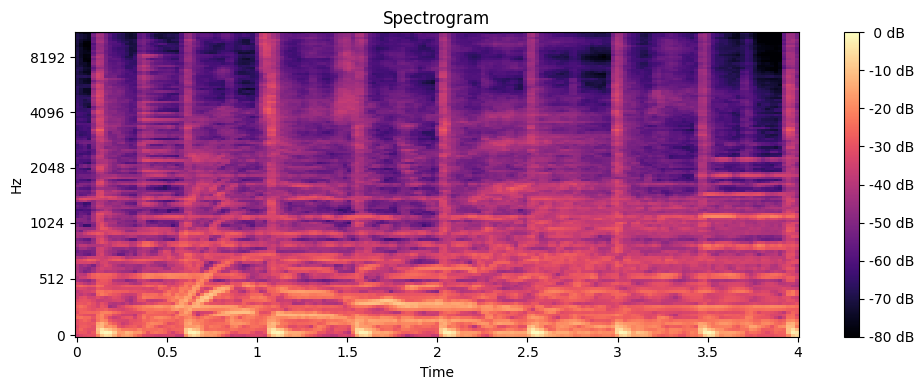

(128, 173)


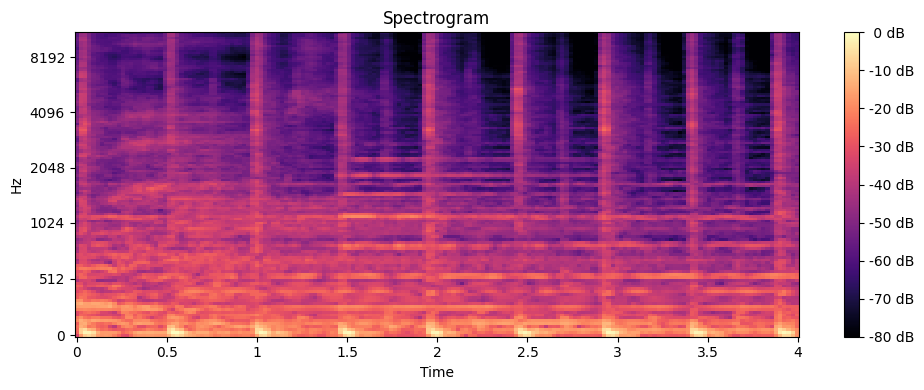

(128, 173)


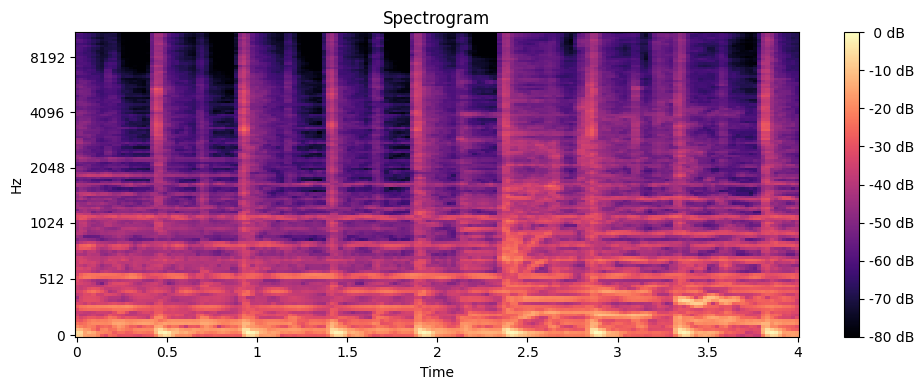

(128, 173)


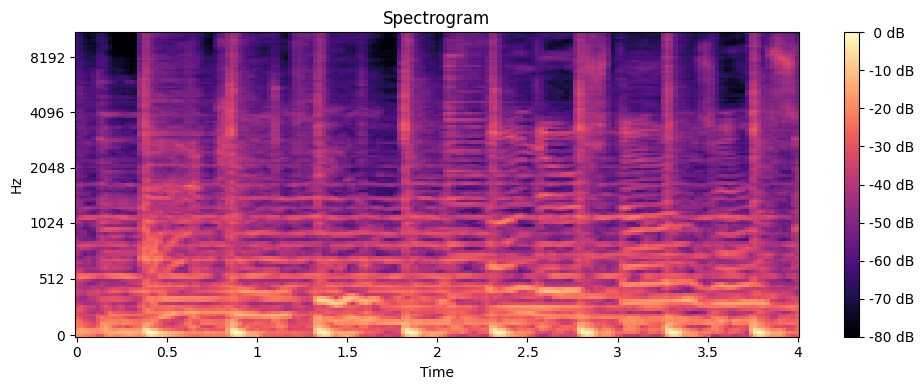

(128, 173)


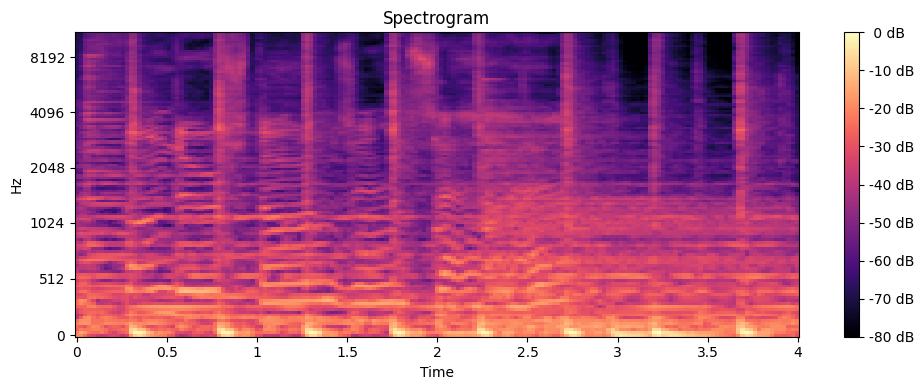

(128, 173)


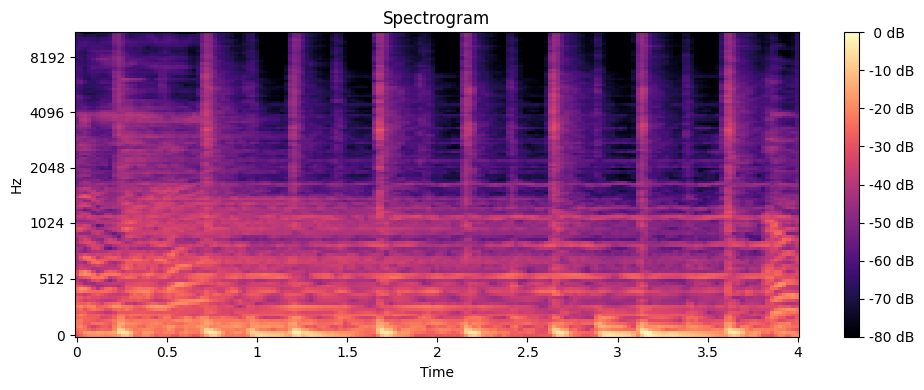

(128, 173)


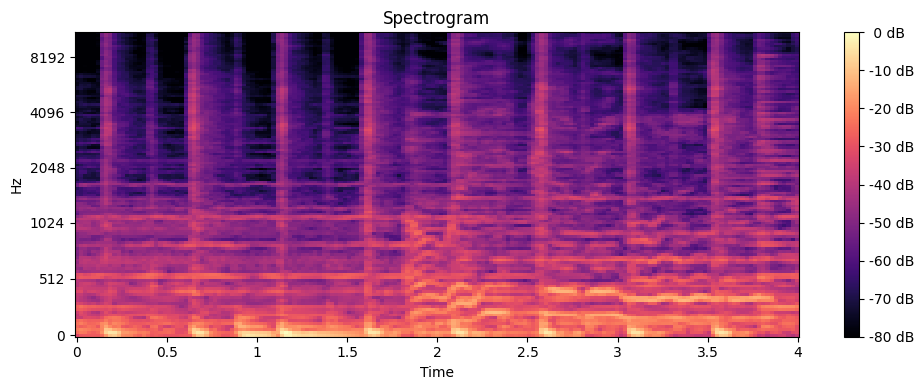

(128, 173)


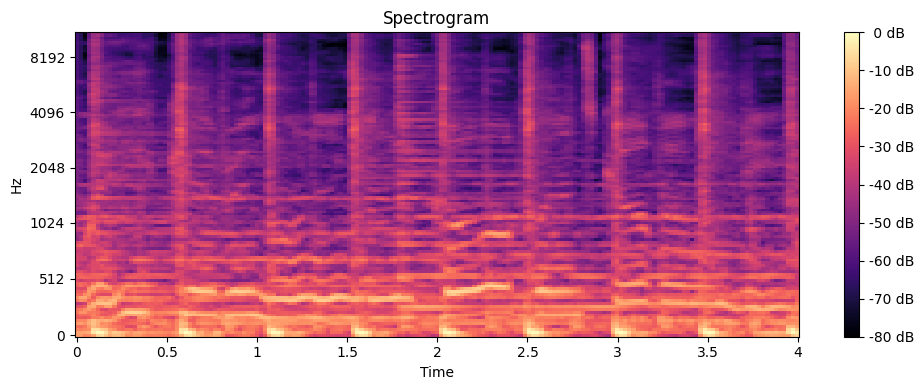

(128, 173)


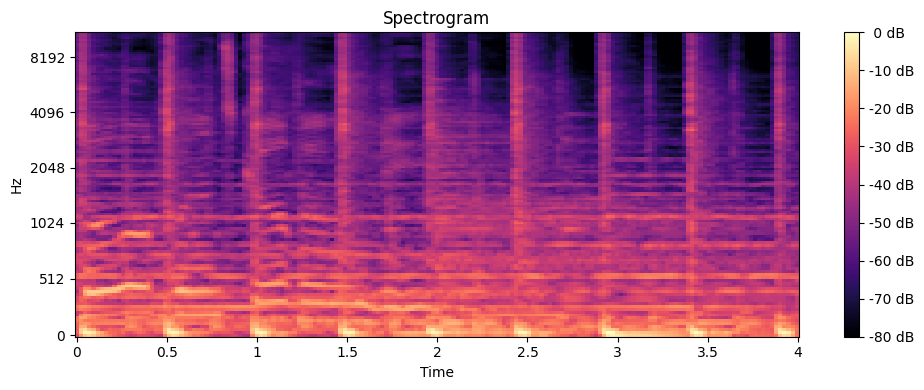

(128, 173)


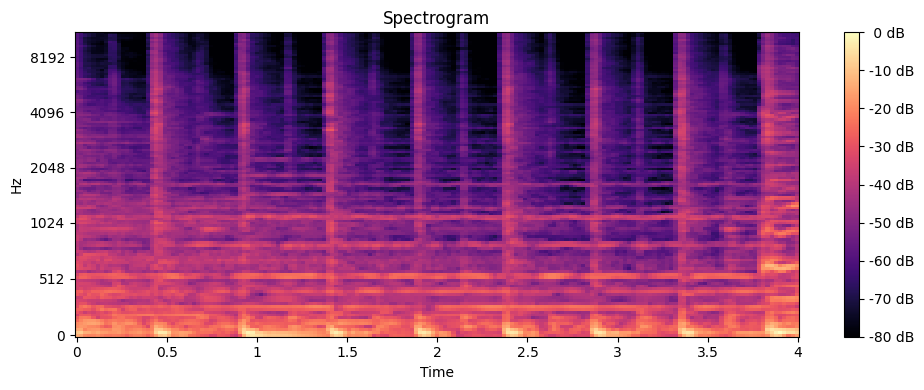

(128, 173)


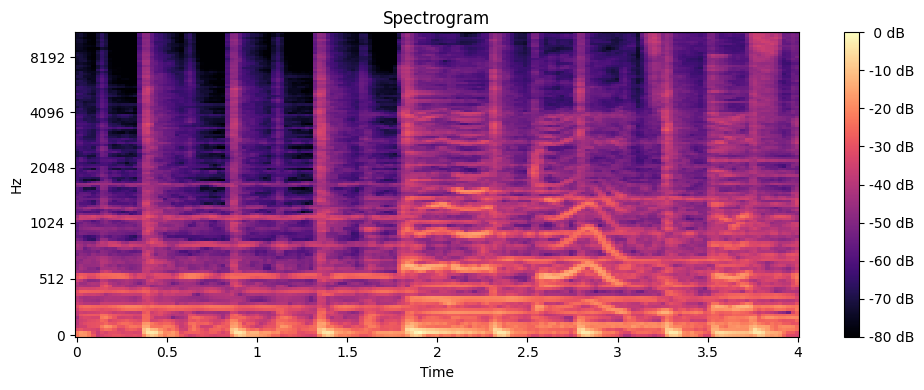

(128, 87)


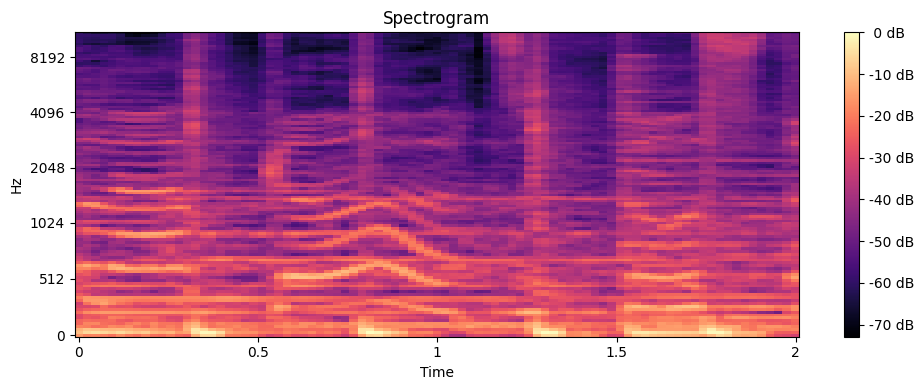

In [ ]:
plot_melspectrogram_chunks(audio_file,sr)

### Các đặc trưng khác

Trước khi giải các bài toán về âm thanh, ta cần phải tìm hiểu về các đặc trưng khác của âm thanh ngoài phổ và sóng âm.

* **Zero Crossing Rate**

Đây là tỷ lệ mà tín hiệu thay đổi từ giá trị dương sang giá trị âm (hoặc ngược lại) trong một khoảng thời gian nhất định. Đây là một đặc trưng phổ biến trong xử lý tín hiệu âm thanh, đặc biệt hữu ích để phân biệt giữa âm thanh tông cao (như giọng nói) và âm thanh ồn hoặc nhạc cụ.

In [ ]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

35336


* **Harmonics and Perceptrual (Hài âm và đặc trưng cảm nhận)**

  * Hài âm (Harmonics) là các tần số bội số của tần số cơ bản, tạo ra màu sắc âm thanh (timbre) mà tai người không thể phân biệt riêng lẻ, giúp phân biệt giữa các nhạc cụ hoặc giọng nói.
  * Đặc trưng cảm nhận (Perceptual features) liên quan đến cảm nhận của con người về âm thanh, như nhịp điệu và cảm xúc, ví dụ âm thanh mạnh mẽ hoặc thay đổi nhanh có thể gợi cảm giác phấn khích hoặc căng thẳng.

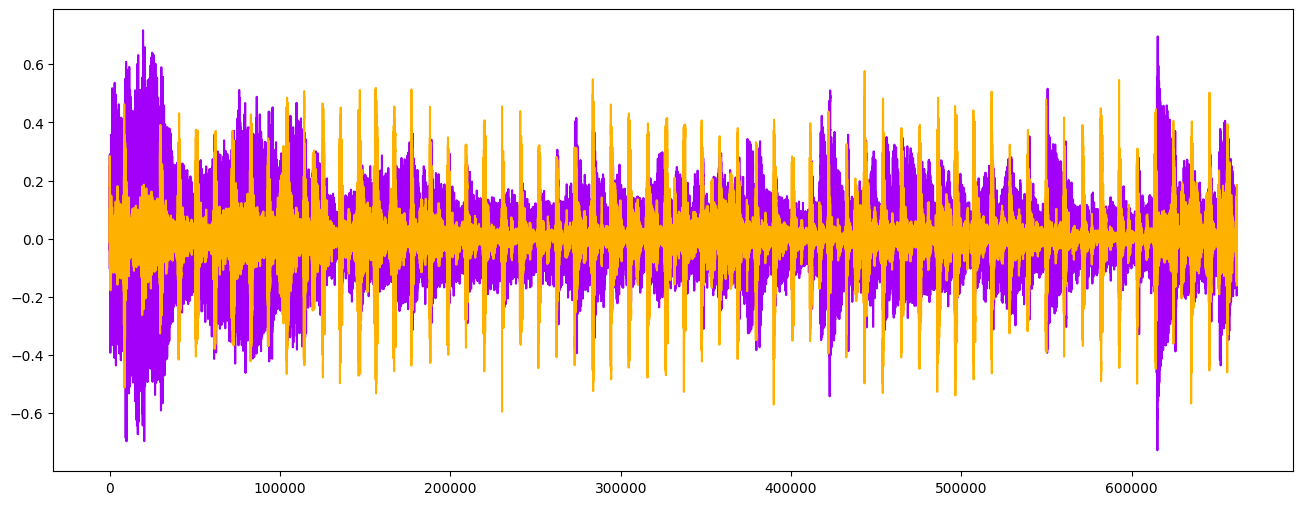

In [ ]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (16, 6))
plt.plot(y_harm, color = '#A300F9');
plt.plot(y_perc, color = '#FFB100');

* **Tempo (BPM - Beats Per Minute)**

Tempo là tốc độ của một bản nhạc, được đo bằng số nhịp (beats) trong một phút (BPM).

In [ ]:
tempo, _ = librosa.beat.beat_track(y=y, sr = sr)
tempo

array([123.046875])

* **Spectral centroid (Trung tâm phổ)**

Trung tâm phổ (Spectral Centroid) là đặc trưng âm thanh chỉ ra vị trí "trung tâm khối lượng" của âm thanh, phản ánh nơi có nhiều năng lượng tần số nhất trong phổ âm thanh. Nó được tính toán như trung bình có trọng số của các tần số có mặt trong âm thanh, với trọng số là biên độ hoặc năng lượng của mỗi tần số.


Trung tâm phổ được tính bằng công thức:  
$$
\text{Spectral Centroid} = \frac{\sum_{i=1}^{N} f_i \cdot A_i}{\sum_{i=1}^{N} A_i}
$$
Trong đó:  
- $ f_i $: Tần số thứ $ i $.  
- $ A_i $: Biên độ (hoặc năng lượng) tại tần số $ f_i $.  
- $ N $: Tổng số tần số trong phổ.



In [ ]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(y=audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids: [1634.42320108 1831.52183792 1874.61319931 ... 2426.02778373 2623.14271218
 2401.15367326] 

Shape of Spectral Centroids: (1293,) 

frames: range(0, 1293) 

t: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 2.99537415e+01
 2.99769615e+01 3.00001814e+01]


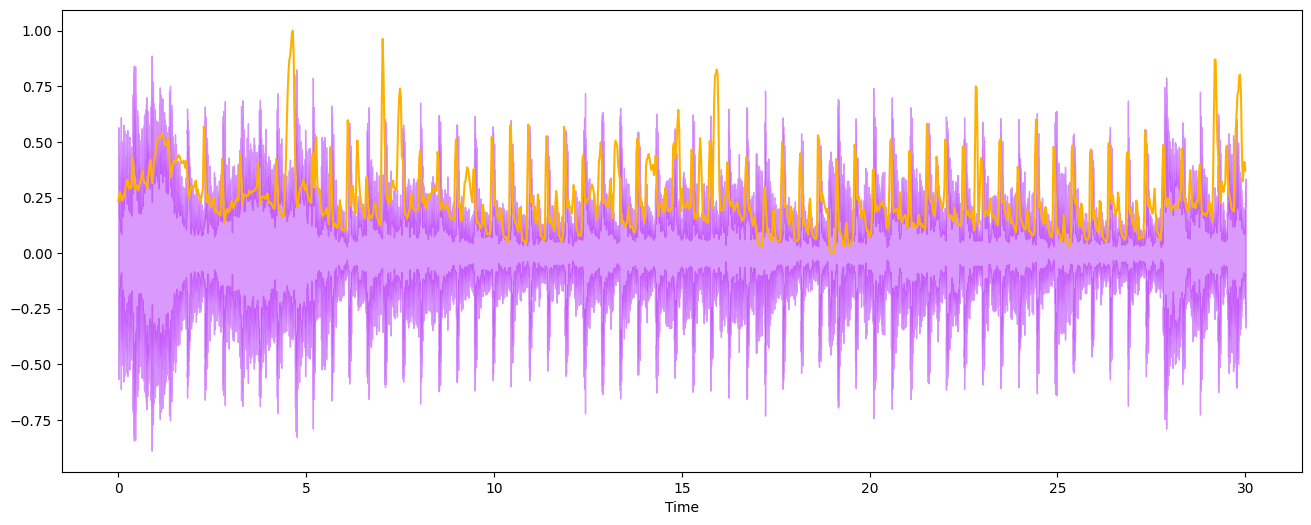

In [ ]:
#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveshow(y=audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_centroids), color='#FFB100');

* **Spectral Rolloff**

Spectral Rolloff ("Điểm cắt phổ" hoặc "Điểm cuộn phổ") là một đặc trưng âm thanh đo lường tần số dưới đó một tỷ lệ phần trăm nhất định của năng lượng phổ tổng thể nằm, ví dụ như 85%. Nó giúp mô tả hình dạng của tín hiệu âm thanh và phân biệt giữa các loại âm thanh có đặc trưng phổ khác nhau.

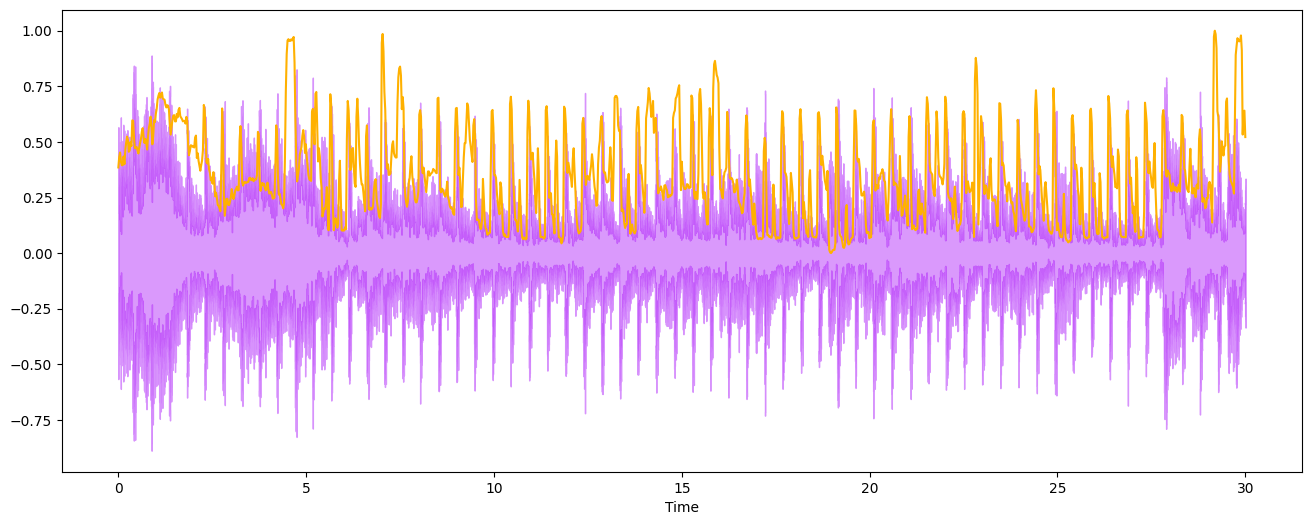

In [ ]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(y = audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveshow(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

* **Mel-Frequency Cepstral Coefficients (MFCC):**

là tập hợp các đặc trưng (thường từ 10–20) mô tả hình dạng tổng thể của phổ âm thanh. MFCCs mô phỏng đặc điểm của giọng người, giúp phân tích và nhận dạng giọng nói hoặc âm thanh.

mfccs shape: (20, 1293)


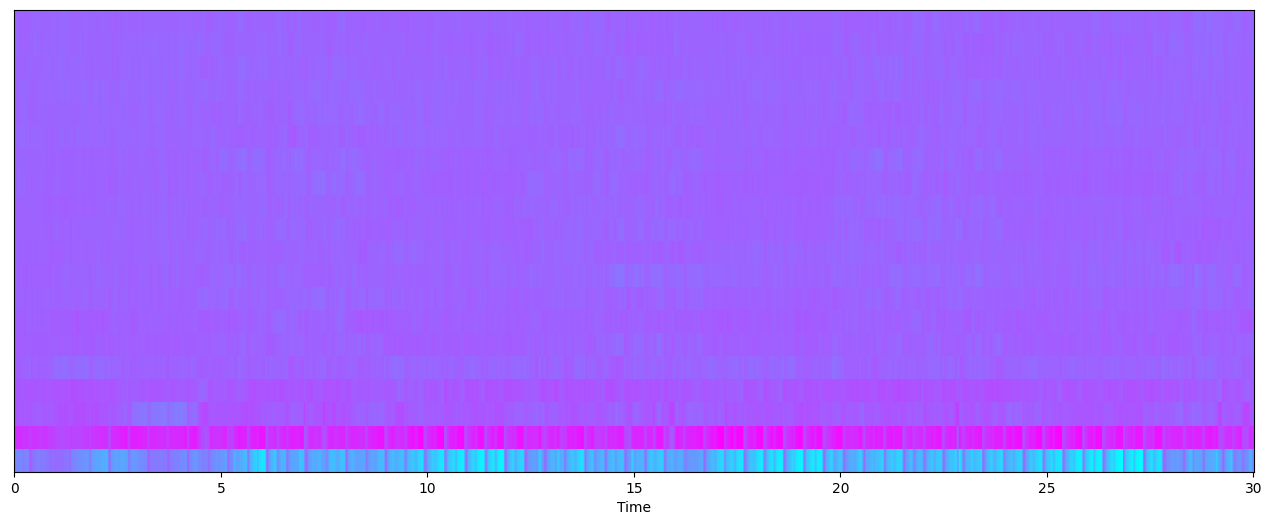

In [ ]:
mfccs = librosa.feature.mfcc(y = audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

#Displaying  the MFCCs:
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Mean: 3.392809e-09 

Var: 1.0


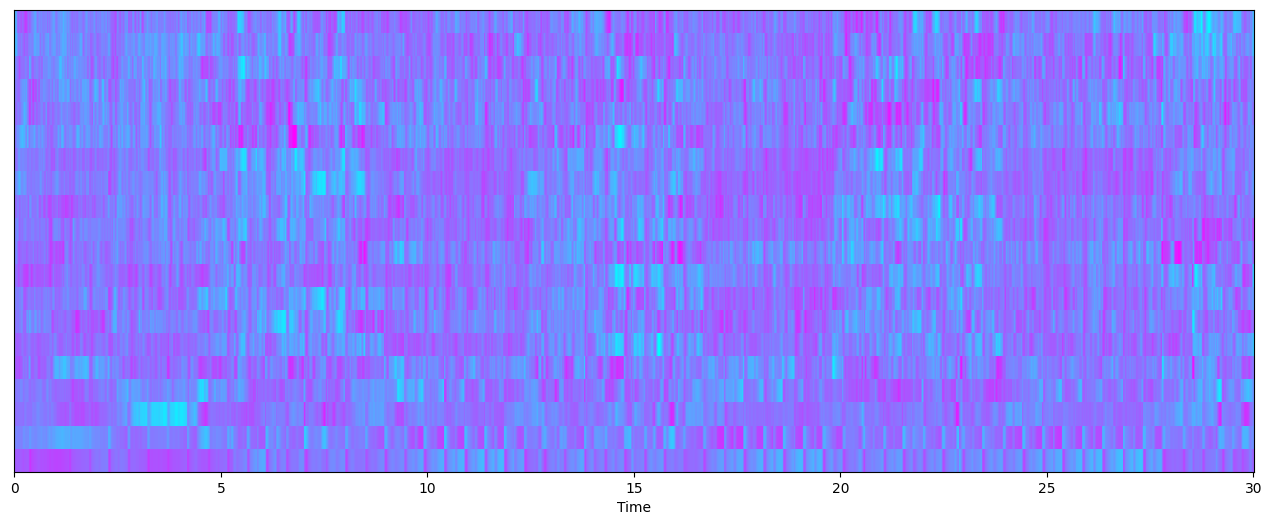

In [ ]:
# Chuẩn hoá dữ liệu và trực quan hoá lại

# Perform Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean:', mfccs.mean(), '\n')
print('Var:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

* **Chroma Frequencies**

là đặc trưng âm thanh đại diện cho âm nhạc, trong đó toàn bộ phổ âm thanh được chiếu lên 12 bin, tương ứng với 12 nửa cung trong một quãng tám nhạc. Điều này giúp phân tích các yếu tố hòa âm trong âm nhạc.

Chromogram shape: (12, 133)


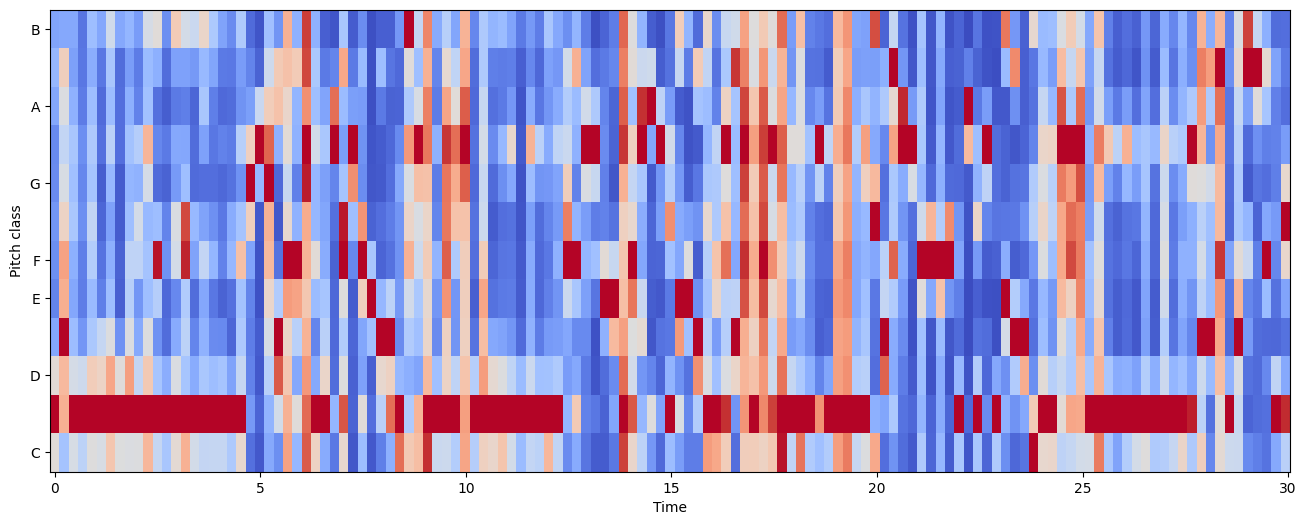

In [ ]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram
chromagram = librosa.feature.chroma_stft(y=audio_file, sr=sr, hop_length=hop_length)
print('Chromogram shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm');

## Khai phá dữ liệu

* Trong phần này, ta sẽ sử dụng file `features_30_sec.csv`. File này chứa các đặc trưng mà ta đã tìm hiểu ở phần trước được trích xuất trên toàn bộ độ dài của các tệp âm thanh trong bộ dữ liệu (mỗi tệp dài 30 giây).

* File csv có 1000 dòng (10 thể loại mỗi thể loại có 100 bài) và 60 cột gồm tên của tệp âm thanh, thể loại của bài đó và 58 đặc trưng gồm các giá trị trung bình (mean) và phương sai (variance).

In [ ]:
data = pd.read_csv(f'{general_path}/features_30_sec.csv')
data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516           213843.755497  ...   55.356403   
2              1747.702312            76254.192257  ...   40.598766   
3              1596.412872           166441.494769  ...   44.427753   
4              1748.172116            88445.209036  ...   86.099236   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -1.690215   36.524071    -0.408979   41.597103    -2.303523   55.062923   
1    -0.731125   60.314529     0.295073   48.120598    -0.283518   51.106190   
2    -7.729093   47.639427    -1.816407   52.382141    -3.439720   46.639660   
3    -3.319597   50.206673     0.636965   37.319130    -0.619121   37.259739   
4    -5.454034   75.269707    -0.916874   53.613918    -4.404827   62.910812   

   mfcc20_mean  mfcc20_var  label  
0     1.221291   46.936035  blues  
1     0.531217   45.786282  blues  
2    -2.231258   30.573025  blues  
3    -3.407448   31.949339  blues  
4   -11.703234   55.195160  blues  

[5 rows x 60 columns]

### Kiểm tra giá trị rỗng

In [ ]:
data.isnull().sum()

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean                 0
mfcc9_var                  0
mfcc10_mean                0
mfcc10_var                 0
mfcc11_mean                0
mfcc11_var                 0
mfcc12_mean                0
mfcc12_var                 0
mfcc13_mean                0
mfcc13_var                 0
mfcc14_mean                0
mfcc14_var                 0
mfcc15_mean                0
mfcc15_var                 0
mfcc16_mean                0
mfcc16_var                 0
mfcc17_mean                0
mfcc17_var                 0
mfcc18_mean                0
mfcc18_var                 0
mfcc19_mean                0
mfcc19_var                 0
mfcc20_mean                0
mfcc20_var                 0
label                      0
dtype: int64

Kết luận: Không có giá rỗng (null) trong bộ dữ liệu này

### Khái quát một chút về dữ liệu

In [ ]:
data.describe()

length  chroma_stft_mean  chroma_stft_var     rms_mean  \
count    1000.000000       1000.000000      1000.000000  1000.000000   
mean   662030.846000          0.378682         0.086340     0.130930   
std      1784.073992          0.081705         0.007735     0.065683   
min    660000.000000          0.171939         0.044555     0.005276   
25%    661504.000000          0.319562         0.082298     0.086657   
50%    661794.000000          0.383148         0.086615     0.122443   
75%    661794.000000          0.435942         0.091256     0.175682   
max    675808.000000          0.663685         0.108111     0.397973   

           rms_var  spectral_centroid_mean  spectral_centroid_var  \
count  1000.000000             1000.000000           1.000000e+03   
mean      0.003051             2201.780898           4.696916e+05   
std       0.003634              715.960600           4.008995e+05   
min       0.000004              570.040355           7.911251e+03   
25%       0.000942             1627.697311           1.843505e+05   
50%       0.001816             2209.263090           3.384862e+05   
75%       0.003577             2691.294667           6.121479e+05   
max       0.027679             4435.243901           3.036843e+06   

       spectral_bandwidth_mean  spectral_bandwidth_var  rolloff_mean  ...  \
count              1000.000000             1000.000000   1000.000000  ...   
mean               2242.541070           137079.155165   4571.549304  ...   
std                 526.316473            96455.666326   1574.791602  ...   
min                 898.066208            10787.185064    749.140636  ...   
25%                1907.240605            67376.554428   3380.069642  ...   
50%                2221.392843           111977.548036   4658.524473  ...   
75%                2578.469836           182371.576801   5533.810460  ...   
max                3509.646417           694784.811549   8677.672688  ...   

       mfcc16_mean   mfcc16_var  mfcc17_mean   mfcc17_var  mfcc18_mean  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      1.148144    60.730958    -3.966028    62.633624     0.507696   
std       4.578948    33.781951     4.549697    33.479172     3.869105   
min     -15.693844     9.169314   -17.234728    13.931521   -11.963694   
25%      -1.863280    40.376442    -7.207225    40.830875    -2.007015   
50%       1.212809    52.325077    -4.065605    54.717674     0.669643   
75%       4.359662    71.691755    -0.838737    75.040838     3.119212   
max      13.457150   392.932373    11.482946   406.058868    15.388390   

        mfcc18_var  mfcc19_mean   mfcc19_var  mfcc20_mean   mfcc20_var  
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
mean     63.712586    -2.328761    66.231930    -1.095348    70.126096  
std      34.401977     3.755957    37.174631     3.837007    45.228512  
min      15.420555   -18.501955    13.487622   -19.929634     7.956583  
25%      41.884240    -4.662925    41.710184    -3.368996    42.372865  
50%      54.804890    -2.393862    57.423059    -1.166289    59.186117  
75%      75.385832     0.150573    78.626444     1.312615    85.375374  
max     332.905426    14.694924   393.161987    15.369627   506.065155  

[8 rows x 58 columns]

### Đếm số bài hát mỗi thể loại.

<Axes: xlabel='label'>

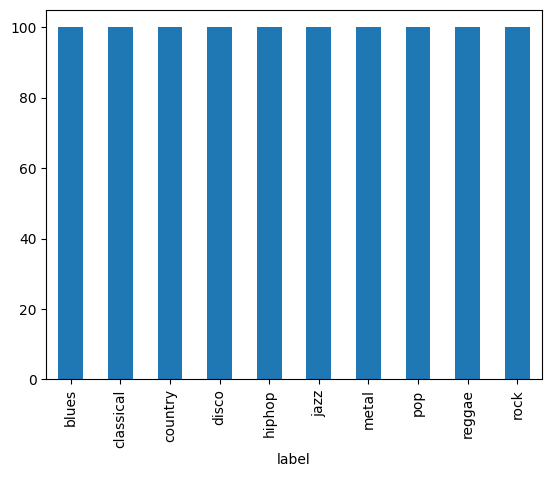

In [ ]:
data['label'].value_counts().plot(kind='bar')

### Trực quan phân phối của dữ liệu

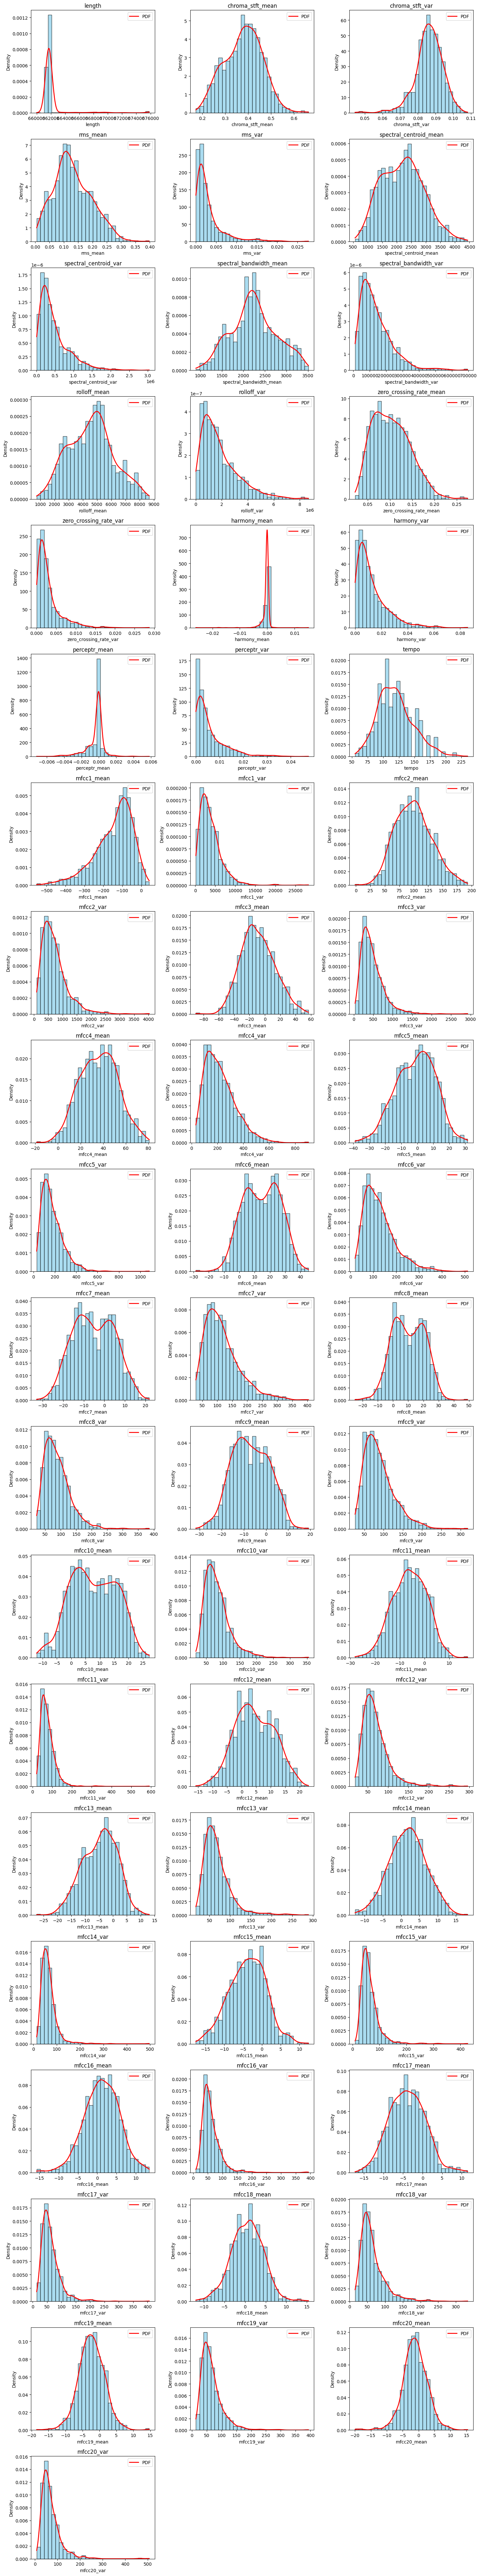

In [ ]:
import math
from scipy.stats import gaussian_kde

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Số lượng cột
num_cols = len(numeric_columns)

# Tính số hàng và số cột cho subplot
ncols = 3  # Số cột trong grid
nrows = math.ceil(num_cols / ncols)  # Số hàng cần thiết

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))

for idx, column in enumerate(numeric_columns):
    row, col = divmod(idx, ncols)
    ax = axes[row, col]

    # Vẽ histogram
    data_column = data[column].dropna()  # Bỏ giá trị null
    ax.hist(data_column, bins=30, color='skyblue', edgecolor='black', alpha=0.7, density=True)

    # Tính và vẽ hàm phân phối xác suất
    kde = gaussian_kde(data_column)
    x_vals = np.linspace(data_column.min(), data_column.max(), 1000)
    ax.plot(x_vals, kde(x_vals), color='red', lw=2, label='PDF')

    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.legend()

# Xóa các ô subplot trống
for idx in range(num_cols, nrows * ncols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


### Kiểm định ANOVA để kiểm tra sự khác biệt của các đặc trưng giữa các nhóm (thể loại)

In [ ]:
import pandas as pd
import scipy.stats as stats

# Lưu tên đặc trưng và nhóm
features = data.select_dtypes(include=['float64', 'int64']).columns
group_column = "label"  # Cột chứa tên nhóm (thay bằng tên cột nhóm thực tế)

# Lưu kết quả kiểm tra
anova_results = []

for feature in features:
    # Tách dữ liệu theo nhóm
    groups = [group[feature].dropna() for name, group in data.groupby(group_column)]

    # Kiểm tra bằng ANOVA
    f_stat, p_value = stats.f_oneway(*groups)

    # Lưu kết quả
    anova_results.append({
        "Feature": feature,
        "F-statistic": f_stat,
        "p-value": p_value
    })

# Chuyển kết quả thành DataFrame
anova_df = pd.DataFrame(anova_results)

# Xem các đặc trưng có sự khác biệt đáng kể
significant_features = anova_df[anova_df["p-value"] < 0.05]
print(significant_features)


                    Feature  F-statistic        p-value
0                    length    10.673559   6.445283e-16
1          chroma_stft_mean   176.453282  7.683150e-199
2           chroma_stft_var    64.103833   1.406555e-92
3                  rms_mean    74.194652  1.485967e-104
4                   rms_var    68.276438   1.307095e-97
5    spectral_centroid_mean    97.484924  6.437171e-130
6     spectral_centroid_var    82.134648  1.546188e-113
7   spectral_bandwidth_mean   116.601879  9.982752e-149
8    spectral_bandwidth_var    29.580172   6.715468e-46
9              rolloff_mean   110.871317  2.939032e-143
10              rolloff_var    52.065245   2.216902e-77
11  zero_crossing_rate_mean    58.716380   6.611053e-86
12   zero_crossing_rate_var    62.333004   2.084503e-90
13             harmony_mean     2.679913   4.439205e-03
14              harmony_var    30.913817   6.837253e-48
15            perceptr_mean     8.134104   1.025650e-11
16             perceptr_var    80.388712  1.3582

### Vẽ Boxplot biểu diễn các đặc trưng theo thể loại và trực quan hoá các giá trị ngoại lai

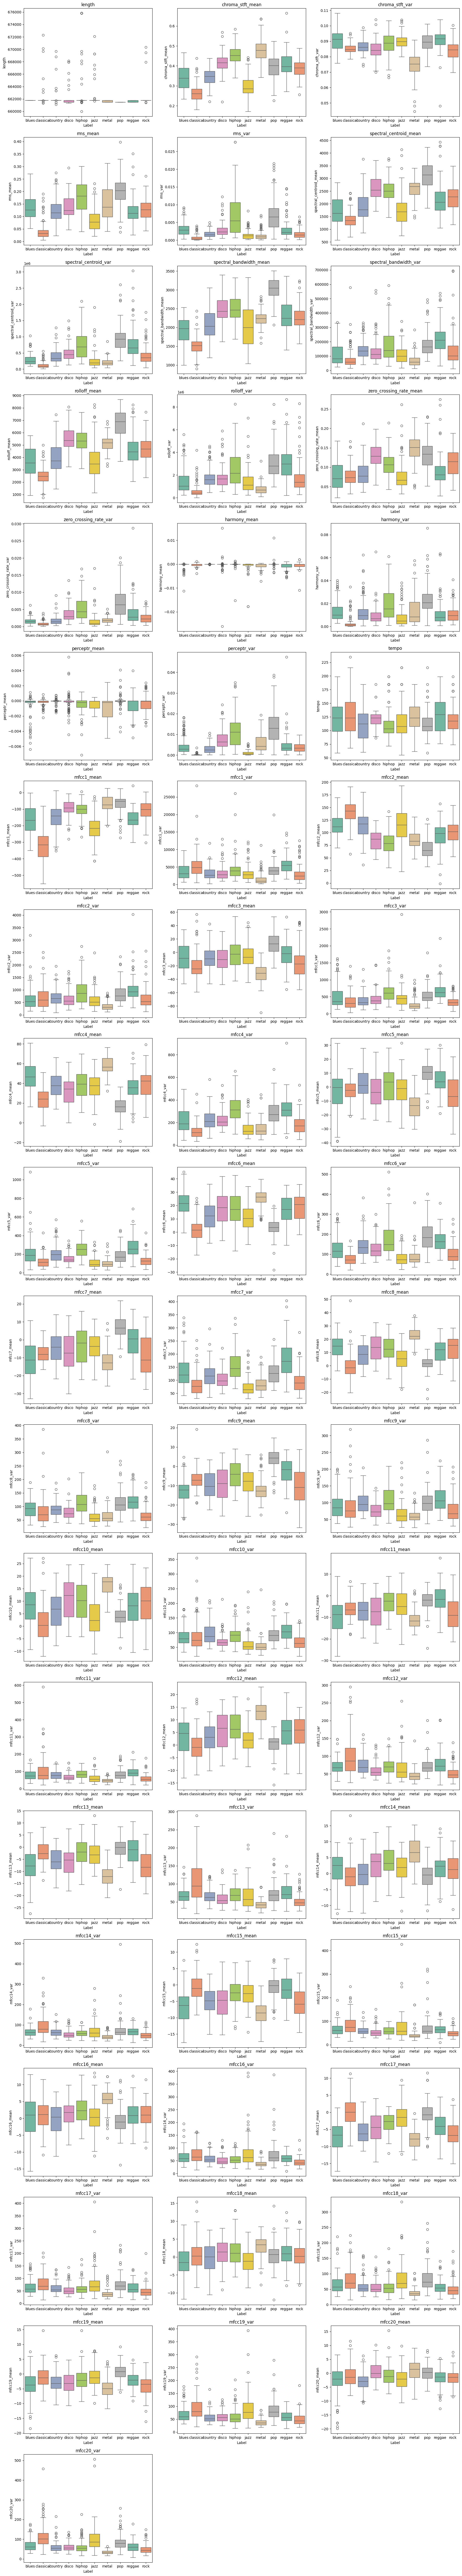

In [ ]:
import math

numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

ncols = 3  # Số cột
nrows = math.ceil(len(numeric_columns) / ncols)  # Số hàng cần thiết

# Kích thước của figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, nrows * 5))
axes = axes.flatten()  # Chuyển thành mảng 1 chiều để dễ truy cập

# Vẽ từng boxplot
for idx, column in enumerate(numeric_columns):
    sns.boxplot(data=data, x="label", y=column, ax=axes[idx], palette="Set2")
    axes[idx].set_title(column, fontsize=12)
    axes[idx].set_xlabel("Label", fontsize=10)
    axes[idx].set_ylabel(column, fontsize=10)

# Ẩn các subplot thừa
for idx in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[idx])


plt.tight_layout()
plt.show()


### Correlation Heatmap (Ma trận tương quan) cho trung bình của các đặc trưng

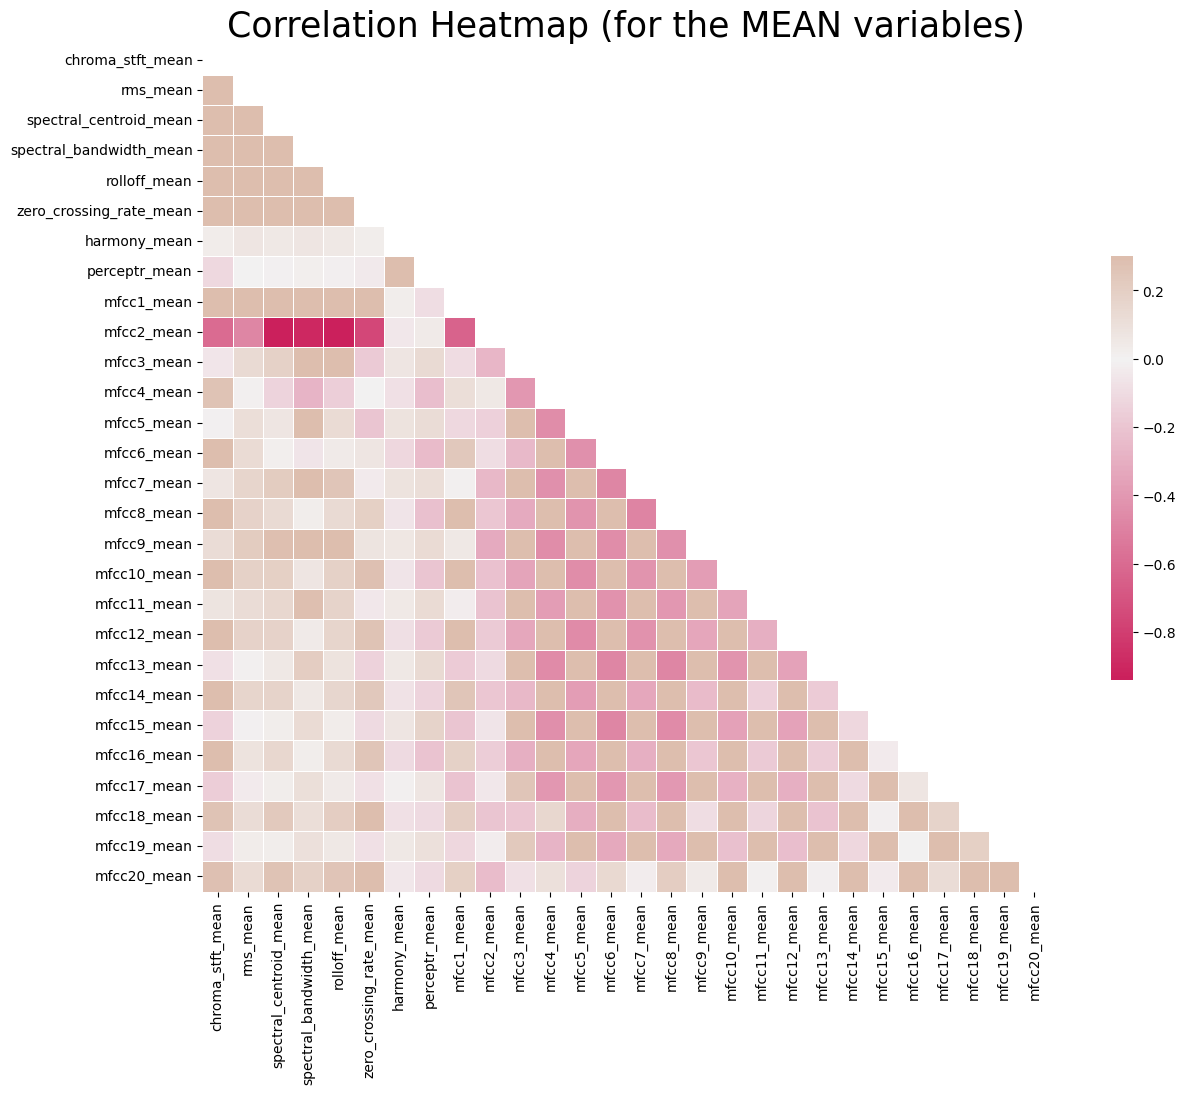

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in data.columns if 'mean' in col]
corr = data[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

### Phân tích thành phần chính (PCA) - Để trực quan hóa các nhóm thể loại nhạc

* Chuẩn hoá dữ liệu
* Thực hiện phân tích
* Sử dụng biếu đồ phân tán (Scatter plot) để trực quan hoá

In [ ]:
from sklearn import preprocessing

data = data.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

#### NORMALIZE X ####
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)


#### PCA 2 COMPONENTS ####
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

pca.explained_variance_ratio_

# 44.93 variance explained

array([0.2439355 , 0.21781804])

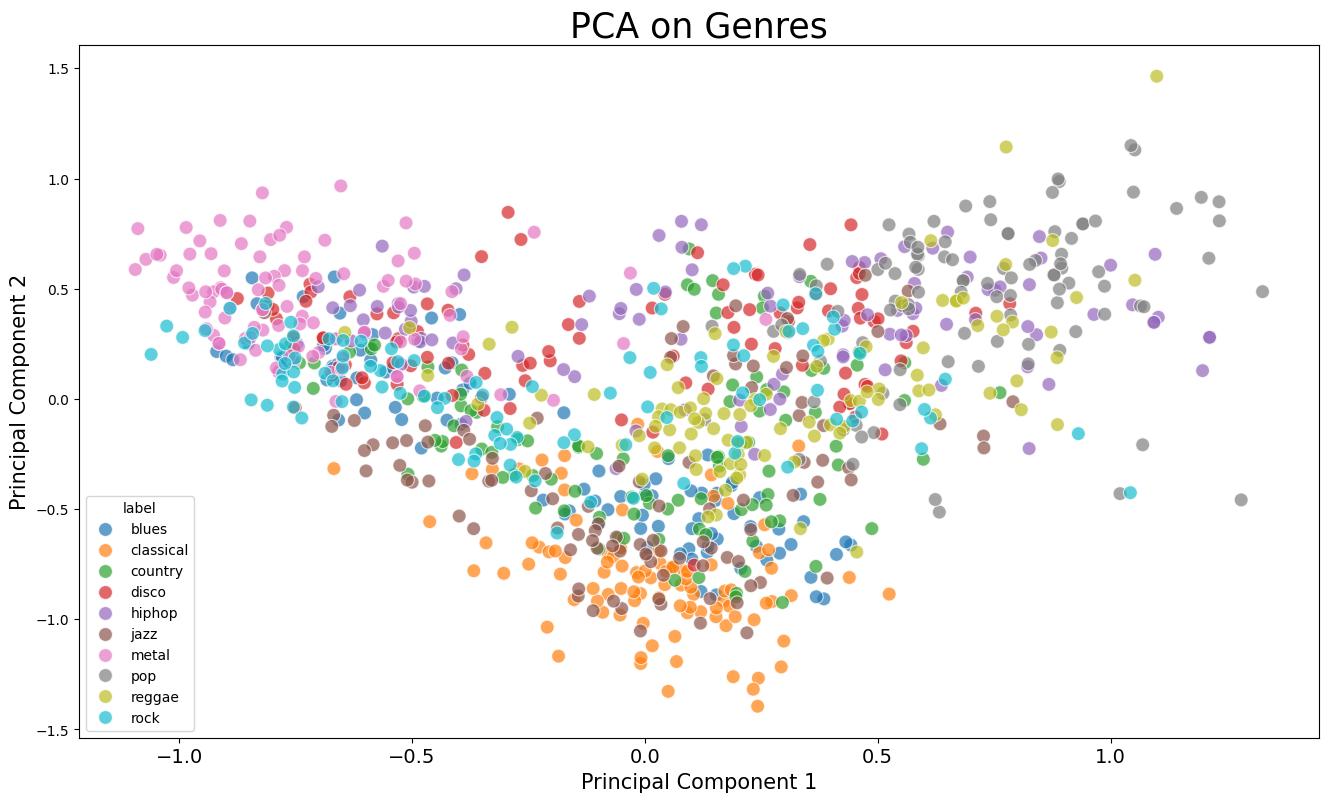

In [ ]:
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "principal component 1", y = "principal component 2", data = finalDf, hue = "label", alpha = 0.7,
               s = 100);

plt.title('PCA on Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA Scattert.jpg")

## Phân loại thể loại âm nhạc (**Music genres classification**)

Trong phần này, ta sẽ xây dựng mô hình mô phân loại thể loại âm nhạc bằng 2 cách:
* Sử dụng file `features_3_sec.csv` (chứa trích xuất đặc trưng của các tệp âm thanh tương tự như file `features_30_sec.csv` nhưng mỗi bài chia thành 10 đoạn 3 giây để làm tăng dữ liệu) và mô hình XGBoost (Extreme Gradient Boosting).
* Trích xuất trực tiếp đặc trưng từ các tệp âm thanh, cụ thể là biểu đồ phổ trên thang đo Mel (Mel Spectrogram) kết hợp với mạng nơ-ron tích chập (Convolutional Neural Network).

### Mô hình XGBoost (Extreme Gradient Boosting)

#### Đọc dữ liệu

In [ ]:
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:]
data.head()

length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0   66149          0.335406         0.091048  0.130405  0.003521   
1   66149          0.343065         0.086147  0.112699  0.001450   
2   66149          0.346815         0.092243  0.132003  0.004620   
3   66149          0.363639         0.086856  0.132565  0.002448   
4   66149          0.335579         0.088129  0.143289  0.001701   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1773.065032          167541.630869              1972.744388   
1             1816.693777           90525.690866              2010.051501   
2             1788.539719          111407.437613              2084.565132   
3             1655.289045          111952.284517              1960.039988   
4             1630.656199           79667.267654              1948.503884   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_var  mfcc17_mean  \
0           117335.771563   3714.560359  ...   39.687145    -3.241280   
1            65671.875673   3869.682242  ...   64.748276    -6.055294   
2            75124.921716   3997.639160  ...   67.336563    -1.768610   
3            82913.639269   3568.300218  ...   47.739452    -3.841155   
4            60204.020268   3469.992864  ...   30.336359     0.664582   

   mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  mfcc20_mean  \
0   36.488243     0.722209   38.099152    -5.050335   33.618073    -0.243027   
1   40.677654     0.159015   51.264091    -2.837699   97.030830     5.784063   
2   28.348579     2.378768   45.717648    -1.938424   53.050835     2.517375   
3   28.337118     1.218588   34.770935    -3.580352   50.836224     3.630866   
4   45.880913     1.689446   51.363583    -3.392489   26.738789     0.536961   

   mfcc20_var  label  
0   43.771767  blues  
1   59.943081  blues  
2   33.105122  blues  
3   32.023678  blues  
4   29.146694  blues  

[5 rows x 59 columns]

#### Tiền xử lý dữ liệu

In [ ]:
y = data['label'] # genre variable.
X = data.loc[:, data.columns != 'label'] #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale.

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data.
X = pd.DataFrame(np_scaled, columns = cols)

NameError: name 'preprocessing' is not defined

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Before splitting the data, encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

#### Chia tập dữ liệu thành tập huấn luyện và kiểm tra theo tỷ lệ 7-3

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Huấn luyện mô hình

In [ ]:
xgb = XGBClassifier(learning_rate=0.05, eval_metric=['mlogloss', 'merror', 'auc'])
history = xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mlogloss:2.19784	validation_0-merror:0.37104	validation_0-auc:0.90947
[1]	validation_0-mlogloss:2.10752	validation_0-merror:0.33667	validation_0-auc:0.92715
[2]	validation_0-mlogloss:2.02870	validation_0-merror:0.31465	validation_0-auc:0.93423
[3]	validation_0-mlogloss:1.95812	validation_0-merror:0.30163	validation_0-auc:0.94043
[4]	validation_0-mlogloss:1.89625	validation_0-merror:0.29897	validation_0-auc:0.94183
[5]	validation_0-mlogloss:1.83768	validation_0-merror:0.29530	validation_0-auc:0.94527
[6]	validation_0-mlogloss:1.78458	validation_0-merror:0.28962	validation_0-auc:0.94757
[7]	validation_0-mlogloss:1.73548	validation_0-merror:0.28562	validation_0-auc:0.94913
[8]	validation_0-mlogloss:1.68955	validation_0-merror:0.28161	validation_0-auc:0.95117
[9]	validation_0-mlogloss:1.64665	validation_0-merror:0.27427	validation_0-auc:0.95332
[10]	validation_0-mlogloss:1.60612	validation_0-merror:0.27060	validation_0-auc:0.95412
[11]	validation_0-mlogloss:1.56831	validat

#### Kiểm tra mô hình

Validation Accuracy: 0.8348348348348348
Training logloss: [2.1978447531158225, 2.1075216584655894, 2.028696455118614, 1.9581209141531108, 1.8962514270811746, 1.837678533893925, 1.7845840167712879, 1.7354804295319337, 1.6895455596921918, 1.6466548680304527, 1.6061218486931628, 1.5683114022901545, 1.5324642803416795, 1.4987138380875458, 1.466056532866962, 1.4353906426940475, 1.405733571674651, 1.3765171903111277, 1.3491158067762434, 1.3235753601019804, 1.299203875365558, 1.2763526982810842, 1.2538892412368638, 1.2327163781788018, 1.21115905586425, 1.1919667738196769, 1.1717425268870574, 1.1536594901854171, 1.1358248869558156, 1.1186637602271658, 1.1022474628847998, 1.0857755267942273, 1.0703448861250688, 1.055827899161362, 1.0420336250587428, 1.0274394272186775, 1.0134184813356257, 0.9999888951097443, 0.9864361026176103, 0.9749486248991193, 0.963353231748144, 0.9525198483660017, 0.9416255093899655, 0.9307652577872192, 0.9201810393714889, 0.9095692794134826, 0.8995439131825934, 0.88934655

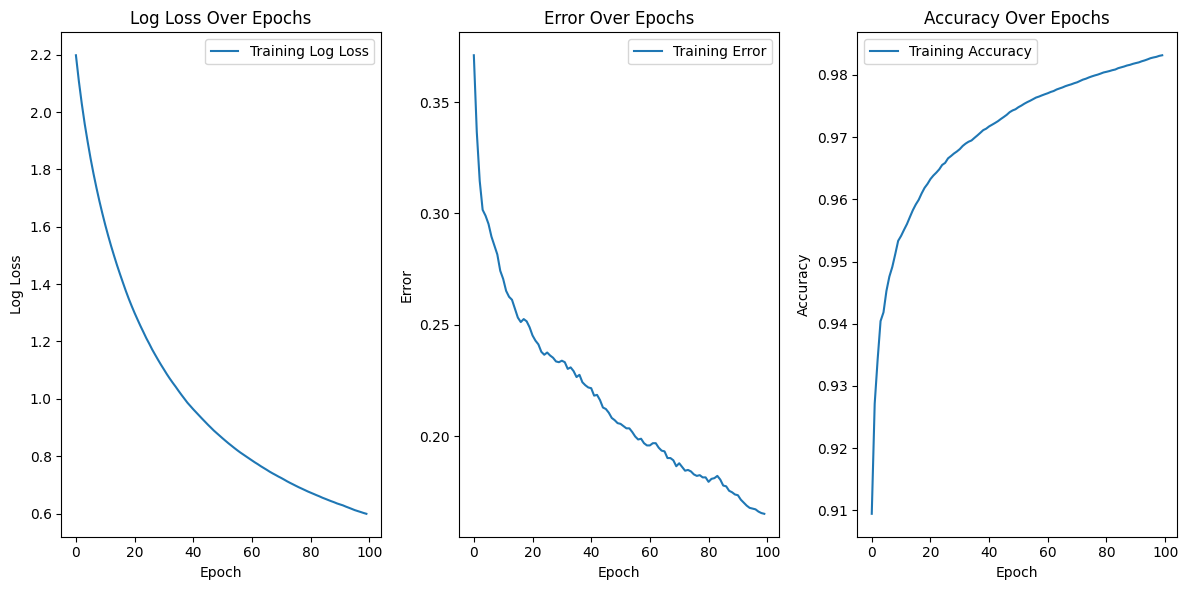

In [ ]:
y_pred = xgb.predict(X_test)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy}")

# Truy xuất các chỉ số đã được theo dõi trong quá trình huấn luyện
evals_result = xgb.evals_result()

# In kết quả logloss, error, và accuracy qua các vòng huấn luyện
print("Training logloss:", evals_result['validation_0']['mlogloss'])
print("Training error:", evals_result['validation_0']['merror'])
print("Training accuracy:", evals_result['validation_0']['auc'])

# Vẽ biểu đồ logloss, error, và accuracy qua các vòng huấn luyện
plt.figure(figsize=(12, 6))

# Biểu đồ logloss
plt.subplot(1, 3, 1)
plt.plot(evals_result['validation_0']['mlogloss'], label='Training Log Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss Over Epochs')
plt.legend()

# Biểu đồ error
plt.subplot(1, 3, 2)
plt.plot(evals_result['validation_0']['merror'], label='Training Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error Over Epochs')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 3, 3)
plt.plot(evals_result['validation_0']['auc'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


#### Confusion matrix

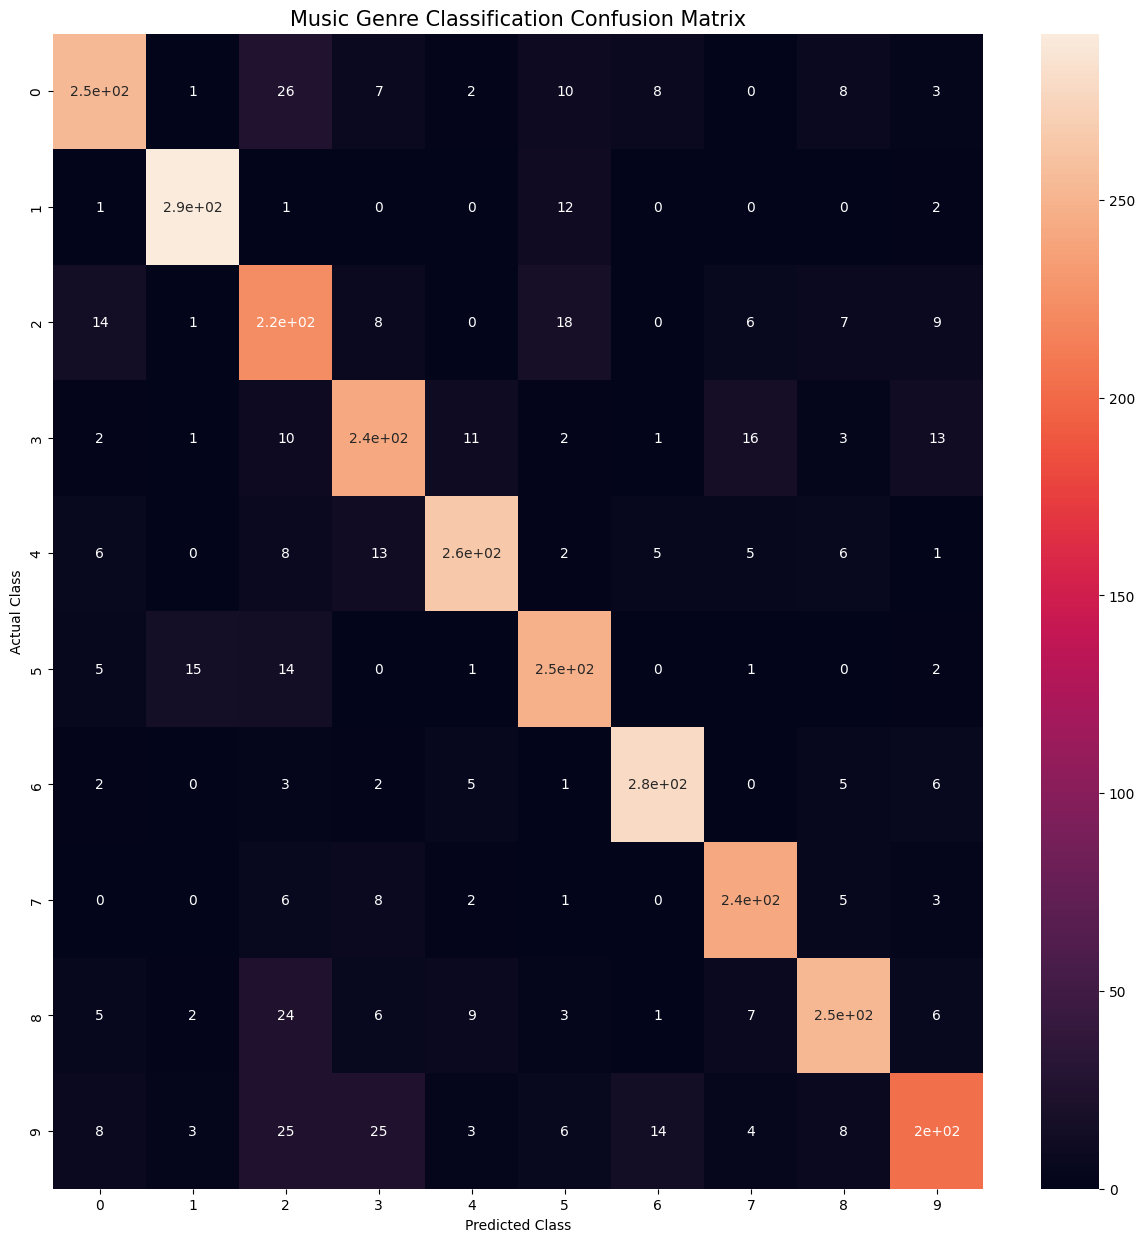

In [ ]:
from sklearn.metrics import confusion_matrix
preds = xgb.predict(X_test)
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()

### Mô hình mạng nơ-ron tích chập (Convolutional Neural Network)

#### Tiền xử lý dữ liệu

In [ ]:
# define folder structure
data_dir = f"{general_path}/genres_original"
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [ ]:
from tensorflow.image import resize
#Load and preprocess audio data
def load_and_preprocess_data(data_dir,classes,target_shape=(150,150)):
    data=[]
    labels=[]

    for i_class,class_name in enumerate(classes):
        class_dir = os.path.join(data_dir,class_name)
        print("Processing--",class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir,filename)
                audio_data,sample_rate = librosa.load(file_path,sr=None)
                #Performing Preprocessing
                #define the duration of each chunk and overlap
                chunk_duration = 4
                overlap_duration = 2

                #Convert duration to sample
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate

                #Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data)-chunk_samples)/(chunk_samples-overlap_samples)))+1

                #iterate over each chunks
                for i in range(num_chunks):
                    #Calculate start and end indices of the chunk
                    start = i*(chunk_samples-overlap_samples)
                    end = start+chunk_samples
                    #Extract the chunk audio
                    chunk = audio_data[start:end]
                    #Melspectrogram part
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk,sr=sample_rate)
                    #Resize matrix based on provided target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram,axis=-1),target_shape)
                    #Append data to list
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    #Return
    return np.array(data),np.array(labels)


In [ ]:
data, labels = load_and_preprocess_data(data_dir,classes)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [ ]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels,num_classes = len(classes)) # Converting labels to one-hot encoding

#### Chia tập dữ liệu thành tập huấn luyện và kiểm tra theo tỷ lệ 8-2

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#### Xây dựng và huấn luyện mô hình

In [ ]:
model = tf.keras.models.Sequential()

# Block 1
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Block 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Block 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# Block 4
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.0025)))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0025)))
model.add(MaxPool2D(pool_size=2, strides=2))

# Block 5
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.0025)))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.0025)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(units=1200, activation='relu', kernel_regularizer=l2(0.0025)))
model.add(Dropout(0.45))

# Output Layer
model.add(Dense(units=len(classes), activation='softmax', kernel_regularizer=l2(0.0025)))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 127ms/step - accuracy: 0.1924 - loss: 8.1042 - val_accuracy: 0.3612 - val_loss: 5.4927
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.4227 - loss: 4.9030 - val_accuracy: 0.5524 - val_loss: 3.6576
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.5712 - loss: 3.4645 - val_accuracy: 0.6368 - val_loss: 2.8344
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.6208 - loss: 2.7310 - val_accuracy: 0.6968 - val_loss: 2.2582
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.6706 - loss: 2.2376 - val_accuracy: 0.6935 - val_loss: 1.9563
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - accuracy: 0.7121 - loss: 1.8765 - val_accuracy: 0.7438 - val_loss: 1.6561
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.7415 - loss: 1.6435 - val_accuracy: 0.7582 - val_loss: 1.4780
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.7703 - loss: 1.4296 -

In [ ]:
# Save the model
model.save("Trained_model.h5")

#### Kiểm tra mô hình

Kiểm tra trên tập train

In [ ]:
#Model evaluation on Training set
train_loss,train_accuracy = model.evaluate(X_train,Y_train)

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9532 - loss: 0.4261


Kiểm tra trên tập test

In [ ]:
#Model evaluation on Validation set
val_loss,val_accuracy = model.evaluate(X_test,Y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8486 - loss: 0.7468


Trực quan hoá loss

In [ ]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [ ]:
#Reloading Training history
import json
with open("training_hist.json",'r') as json_file:
    training_history_data = json.load(json_file)

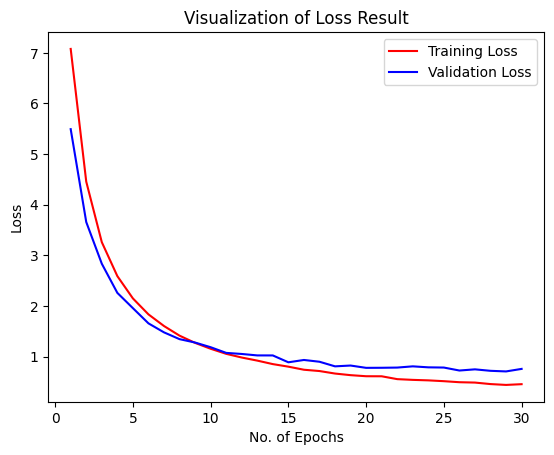

In [ ]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

Trực quan hoá độ chính xác

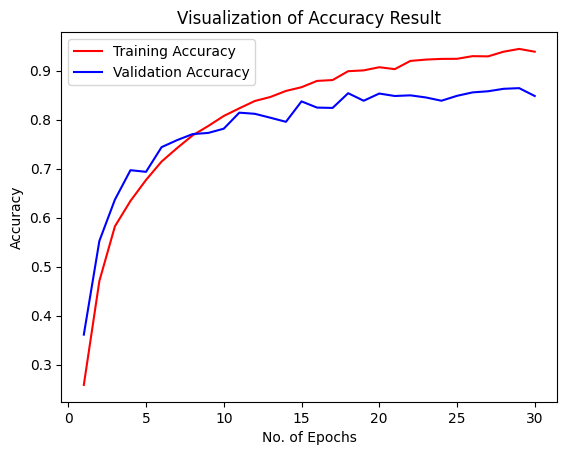

In [ ]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

#### Confusion matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


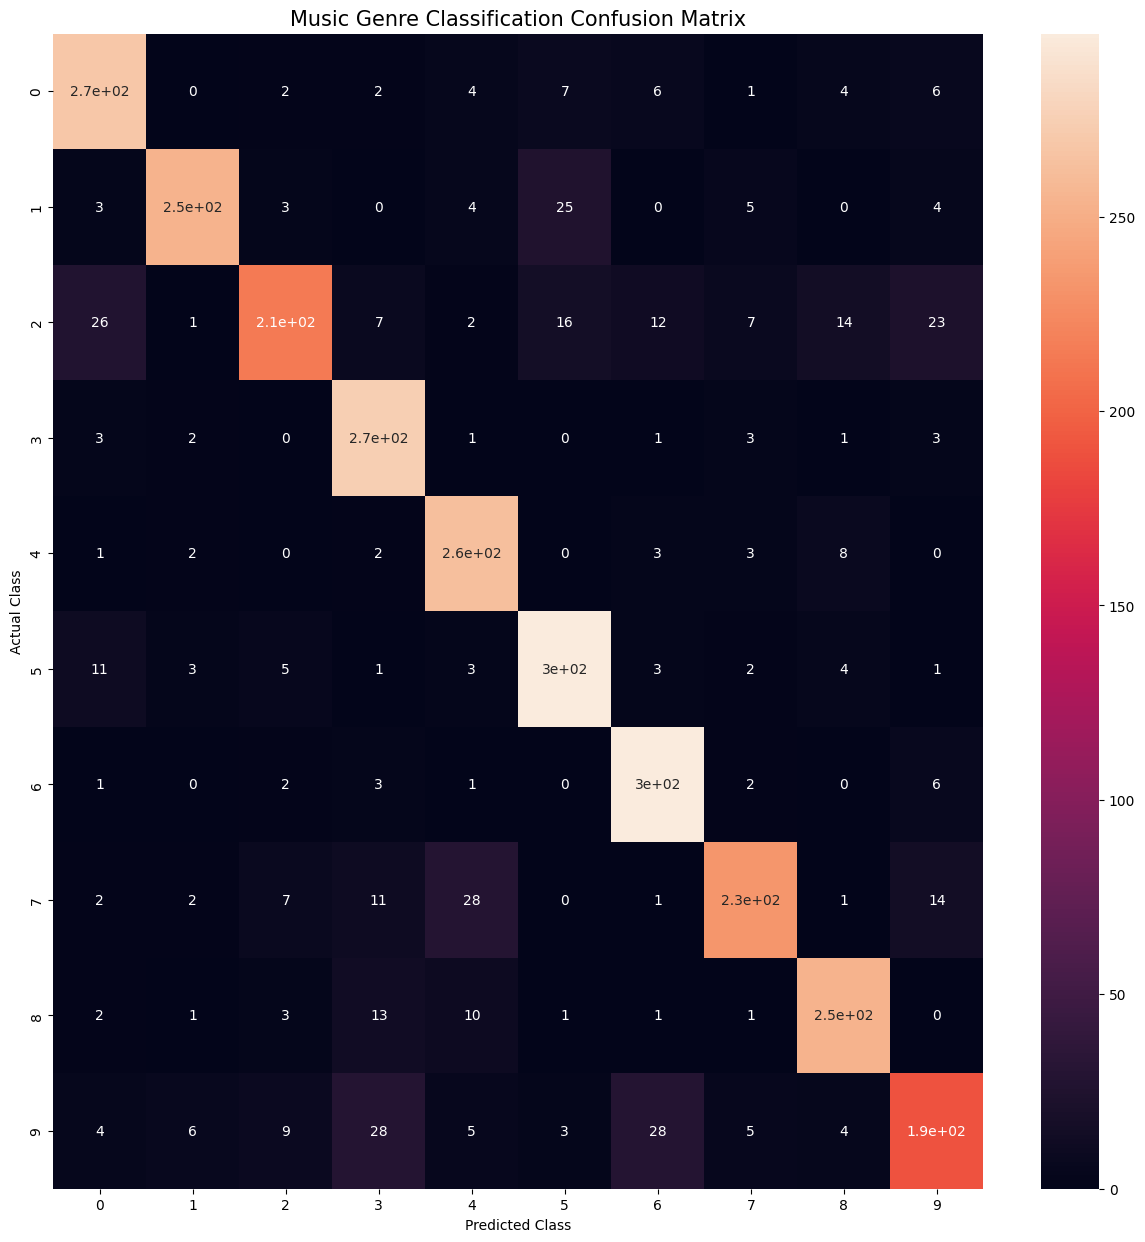

In [ ]:
y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred,axis=1)
true_categories = np.argmax(Y_test,axis=1)
cm = confusion_matrix(true_categories,predicted_categories)
plt.figure(figsize=(15,15))
sns.heatmap(cm,annot=True,annot_kws={"size":10})
plt.xlabel("Predicted Class",fontsize=10)
plt.ylabel("Actual Class",fontsize=10)
plt.title("Music Genre Classification Confusion Matrix",fontsize=15)
plt.show()

### Kiểm thử mô hình

#### Trích xuất đặc trưng của một tệp âm thanh



In [ ]:
# Load and preprocess audio data
def load_and_preprocess_file(file_path, target_shape=(150, 150)):
    data = []
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
    # Define the duration of each chunk and overlap
    chunk_duration = 4  # seconds
    overlap_duration = 2  # seconds

    # Convert durations to samples
    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate

    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    # Iterate over each chunk
    for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples

                    # Extract the chunk of audio
        chunk = audio_data[start:end]

                    # Compute the Mel spectrogram for the chunk
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)

                #mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        data.append(mel_spectrogram)

    return np.array(data)

#### Lấy tệp để kiểm thử

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1hLX5XlvLIUHrYHAIF03NKK5hVJS1S7Xr'
output = '/content/audio.zip'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1hLX5XlvLIUHrYHAIF03NKK5hVJS1S7Xr
From (redirected): https://drive.google.com/uc?id=1hLX5XlvLIUHrYHAIF03NKK5hVJS1S7Xr&confirm=t&uuid=76d9ecea-7cc4-4674-8b97-5a0ffd686e3c
To: /content/audio.zip
100%|██████████| 34.8M/34.8M [00:00<00:00, 67.8MB/s]


'/content/audio.zip'

In [ ]:
import zipfile

zip_file_path = '/content/audio.zip'
output_dir = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

#### Đọc tệp âm thanh và thực hiện đoán thể loại

In [ ]:
file_path = "/content/audio/metal_music.mp3"
test = load_and_preprocess_file(file_path)

NameError: name 'load_and_preprocess_file' is not defined

In [ ]:
def model_prediction(test):
  pred = model.predict(test)
  predicted_category = np.argmax(pred,axis=1)
  unique_elements, counts = np.unique(predicted_category, return_counts=True)
  max_counts = np.max(counts)
  max_elements = unique_elements[counts == max_counts]
  return max_elements[0]

In [ ]:
c_index = model_prediction(test)
print(f"Music genre prediction of file {file_path} is {classes[c_index]}.")

## Xây dựng hệ thống đề xuất nhạc đơn giản (Music recommendation system)

Trong phần này, ta sẽ sử dụng `cosine_similarity` để xây dựng hệ thống đề xuất.

In [ ]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

Scaled data type: <class 'numpy.ndarray'>


* **Giới thiệu về `cosine_similarity`**

Cosine similarity là một chỉ số đo độ tương đồng giữa hai vector trong không gian đa chiều, được tính bằng cách đo góc giữa chúng. Nó rất hữu ích trong việc đo lường mức độ tương tự giữa các đối tượng, đặc biệt là trong các bài toán xử lý ngôn ngữ tự nhiên và nhận diện mẫu.

* **Cách tính Cosine Similarity:**

Đối với hai vector **A** và **B**, cosine similarity được tính như sau:

$$
\text{Cosine Similarity} = \frac{A \cdot B}{\|A\| \|B\|}
$$

Trong đó:
- $ A \cdot B $ là tích vô hướng (dot product) của hai vector.
- $ \|A\| $ và $ \|B\| $ là độ dài (norm) của mỗi vector.

Khi áp dụng cosine similarity trong bài toán phân loại thể loại bài hát, ta có thể tính toán độ tương đồng giữa tất cả các cặp bài hát trong tập dữ liệu. Điều này dẫn đến một ma trận tương tự có kích thước 1000 x 1000, trong đó mỗi giá trị trong ma trận đại diện cho độ tương đồng giữa hai bài hát.

Ví dụ: Ta có 1000 bài hát, ta sẽ tạo ra một ma trận vuông 1000 x 1000, với mỗi phần tử tại vị trí (i, j) là giá trị cosine similarity giữa bài hát i và bài hát j.
Ma trận này sẽ có tính đối xứng, vì cosine similarity giữa bài hát A và bài hát B luôn bằng cosine similarity giữa bài hát B và bài hát A.

In [ ]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

Similarity shape: (1000, 1000)


filename         blues.00000.wav  blues.00001.wav  blues.00002.wav  \
filename                                                             
blues.00000.wav         1.000000         0.049231         0.589618   
blues.00001.wav         0.049231         1.000000        -0.096834   
blues.00002.wav         0.589618        -0.096834         1.000000   
blues.00003.wav         0.284862         0.520903         0.210411   
blues.00004.wav         0.025561         0.080749         0.400266   

filename         blues.00003.wav  blues.00004.wav  blues.00005.wav  \
filename                                                             
blues.00000.wav         0.284862         0.025561        -0.346688   
blues.00001.wav         0.520903         0.080749         0.307856   
blues.00002.wav         0.210411         0.400266        -0.082019   
blues.00003.wav         1.000000         0.126437         0.134796   
blues.00004.wav         0.126437         1.000000         0.556066   

filename         blues.00006.wav  blues.00007.wav  blues.00008.wav  \
filename                                                             
blues.00000.wav        -0.219483        -0.167626         0.641877   
blues.00001.wav         0.318286         0.415258         0.120649   
blues.00002.wav        -0.028061         0.104446         0.468113   
blues.00003.wav         0.300746         0.324566         0.352758   
blues.00004.wav         0.482195         0.623455         0.029703   

filename         blues.00009.wav  ...  rock.00090.wav  rock.00091.wav  \
filename                          ...                                   
blues.00000.wav        -0.097889  ...       -0.082829        0.546169   
blues.00001.wav         0.404168  ...       -0.098111       -0.325126   
blues.00002.wav        -0.132532  ...       -0.032408        0.561074   
blues.00003.wav         0.295184  ...       -0.320107       -0.206516   
blues.00004.wav         0.471657  ...        0.087605        0.017366   

filename         rock.00092.wav  rock.00093.wav  rock.00094.wav  \
filename                                                          
blues.00000.wav        0.578558        0.662590        0.571629   
blues.00001.wav       -0.370792       -0.191698       -0.330834   
blues.00002.wav        0.590779        0.583293        0.514537   
blues.00003.wav       -0.151132        0.041986       -0.172515   
blues.00004.wav        0.138035        0.104684       -0.034594   

filename         rock.00095.wav  rock.00096.wav  rock.00097.wav  \
filename                                                          
blues.00000.wav        0.610942        0.640835        0.496294   
blues.00001.wav       -0.077301       -0.222119       -0.302573   
blues.00002.wav        0.495707        0.566837        0.589983   
blues.00003.wav       -0.000287        0.020515       -0.107821   
blues.00004.wav        0.063454        0.063546        0.172944   

filename         rock.00098.wav  rock.00099.wav  
filename                                         
blues.00000.wav        0.284958        0.304098  
blues.00001.wav        0.499562        0.311723  
blues.00002.wav        0.216378        0.321069  
blues.00003.wav        0.502279        0.183210  
blues.00004.wav        0.153192        0.061785  

[5 rows x 1000 columns]

In [ ]:
def find_similar_songs(name):
    # Find songs most similar to another song
    series = sim_df_names[name].sort_values(ascending = False)

    # Remove cosine similarity == 1 (songs will always have the best match with themselves)
    series = series.drop(name)

    # Display the 5 top matches
    print("\n*******\nSimilar songs to ", name)
    print(series.head(5))

Danh sách các bài hát giống pop.00019.wav (Britney Spears - Hit me baby one more time)

In [ ]:
# pop.00019 - Britney Spears "Hit me baby one more time"
find_similar_songs('pop.00019.wav')


*******
Similar songs to  pop.00019.wav
filename
pop.00023.wav    0.862836
pop.00034.wav    0.860499
pop.00078.wav    0.829135
pop.00088.wav    0.824456
pop.00091.wav    0.802269
Name: pop.00019.wav, dtype: float64


## Streamlit

In [ ]:
!pip install streamlit
!pip install streamlit tensorflow librosa pyngrok --quiet
!pip install streamlit tensorflow librosa pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.0 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
import librosa
import os
import uuid
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Load the trained model
@st.cache_resource
def load_model():
    return tf.keras.models.load_model('/content/Trained_model.h5')

model = load_model()

# Load recommendation data
@st.cache_data
def load_recommendation_data():
    dataset_path = '/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/features_30_sec.csv'  # Update with the correct path
    data = pd.read_csv(dataset_path, index_col='filename')
    labels = data[['label']]
    data_features = data.drop(columns=['length', 'label'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_features)
    similarity = cosine_similarity(data_scaled)
    sim_df_names = pd.DataFrame(similarity, index=labels.index, columns=labels.index)
    return labels, sim_df_names

labels, sim_df_names = load_recommendation_data()

# Function to preprocess audio
def preprocess_audio(file_path, target_sr=22050, img_size=(150, 150)):
    """
    Preprocess audio file into mel spectrogram and resize it to match model input size.
    """
    audio, sr = librosa.load(file_path, sr=target_sr)
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    resized_spectrogram = np.resize(log_spectrogram, img_size)
    normalized_spectrogram = resized_spectrogram / np.max(resized_spectrogram)
    return normalized_spectrogram[np.newaxis, ..., np.newaxis]

# Function to predict the music genre
def predict_genre(features, model):
    """
    Predict the genre of a given audio file's features using the model.
    """
    try:
        prediction = model.predict(features)
        predicted_genre_index = np.argmax(prediction, axis=1)[0]
        genre_labels = ["Classical", "Disco", "Hip Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock", "Blues", "Country"]
        if 0 <= predicted_genre_index < len(genre_labels):
            return genre_labels[predicted_genre_index], prediction[0][predicted_genre_index]
        else:
            return None, None
    except Exception as e:
        st.error(f"Error during prediction: {e}")
        return None, None

# Function to find similar songs
def find_similar_songs(song_name, sim_df_names):
    """
    Find similar songs based on the cosine similarity of features.
    """
    if song_name not in sim_df_names.index:
        return f"Song '{song_name}' not found in the recommendation database."
    similar_songs = sim_df_names[song_name].sort_values(ascending=False).drop(song_name).head(5)
    return similar_songs

# Streamlit app interface
st.title("Music Genre Prediction and Recommendation")
st.write("Upload an audio file for genre prediction and/or recommendation.")

# File uploader for genre prediction
uploaded_file_for_prediction = st.file_uploader("Choose an audio file for genre prediction", type=["wav", "mp3"])

if uploaded_file_for_prediction is not None:
    unique_filename = f"temp_audio_{uuid.uuid4().hex}.wav"
    with open(unique_filename, "wb") as f:
        f.write(uploaded_file_for_prediction.getbuffer())
    st.audio(uploaded_file_for_prediction, format="audio/wav")
    features = preprocess_audio(unique_filename, img_size=(150, 150))
    genre, confidence = predict_genre(features, model)
    if genre:
        st.write(f"Predicted Genre: **{genre}**")
        st.write(f"Confidence: **{confidence * 100:.2f}%**")
    else:
        st.write("Could not predict the genre. Please check the input or model.")
    os.remove(unique_filename)

# File uploader for recommendations
uploaded_file_for_recommendation = st.file_uploader("Choose an audio file for song recommendations", type=["wav", "mp3"])

if uploaded_file_for_recommendation is not None:
    song_name = uploaded_file_for_recommendation.name
    st.write(f"Uploaded song for recommendation: **{song_name}**")
    recommendations = find_similar_songs(song_name, sim_df_names)
    if isinstance(recommendations, str):  # Error message
        st.write(recommendations)
    else:
        st.write("Here are the top 5 similar songs:")
        for idx, (name, similarity) in enumerate(recommendations.items(), start=1):
            st.write(f"{idx}. {name} (Similarity: {similarity:.2f})")


Writing app.py


In [ ]:
from pyngrok import ngrok

# authtokeA
ngrok.set_auth_token("2r1RuGApCYfhxIzPQHl0Ku0LTNR_77HLx41d9ApUf4QFAEX9E")

# Tạo ngrok tunnel cho cổng 8501 (Streamlit mặc định sử dụng cổng này)
public_url = ngrok.connect("8501")
print('Ngrok URL:', public_url)
!streamlit run app.py &

Ngrok URL: NgrokTunnel: "https://aa0a-34-125-203-113.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.2:8501
  External URL: http://34.125.203.113:8501

2025-01-07 08:27:22.318188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 08:27:22.362285: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 08:27:22.375491: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 08:27:23.983171: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Wa